# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [45]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

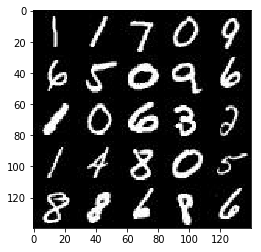

In [46]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

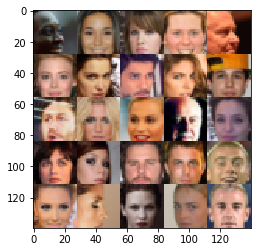

In [47]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [48]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.4.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [49]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    input_images = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_images')
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return (input_images, z_input, learning_rate)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [50]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    # Hyperparameter to control leaky ReLU for the discriminator
    ALPHA_D = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        #Layer 1
        # Input layer is 28x28x(number of colour channels)
        # No batch normalization in the first layer
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(ALPHA_D * conv1, conv1)
        # Add dropout
        dropout1 = tf.layers.dropout(relu1, rate=0.5)
        #14x14x64 now
        
        # Layer 2
        conv2 = tf.layers.conv2d(dropout1, 128, 5, strides=2, padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(conv2, training=True)
        relu2 = tf.maximum(ALPHA_D * bn2, bn2)
        # Add dropout
        dropout2 = tf.layers.dropout(relu2, rate=0.5)
        #7x7x128 now
        
        # Layer 3
        conv3 = tf.layers.conv2d(dropout2, 256, 5, strides=2, padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(conv3, training=True)
        relu3 = tf.maximum(ALPHA_D * bn3, bn3)
        # Add dropout
        dropout3 = tf.layers.dropout(relu3, rate=0.5)
        #4x4x256 now

        # Layer 4
        # Get logits and sigmoid output
        flat = tf.contrib.layers.flatten(dropout3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [51]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    # Hyperparameter to control leaky ReLU for generator
    ALPHA_G = 0.05
    with tf.variable_scope('generator', reuse=not is_train):
        # Layer 1
        # Fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Flatten
        flat = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(flat, training=is_train)
        relu1 = tf.maximum(ALPHA_G * bn1, bn1)
        # Add dropout
        dropout1 = tf.layers.dropout(relu1, rate=0.5)
        # 7x7x512 now
        
        # Layer 2
        # Convolution transpose.
        convt2 = tf.layers.conv2d_transpose(dropout1, 256, 5, strides=2, padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(convt2, training=is_train)
        relu2 = tf.maximum(ALPHA_G * bn2, bn2)
        # Add dropout
        dropout2 = tf.layers.dropout(relu2, rate=0.5)
        # 14x14x256 now
        
        # Layer 3
        # Convolution transpose.
        convt3 = tf.layers.conv2d_transpose(dropout2, 128, 5, strides=2, padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(convt3, training=is_train)
        relu3 = tf.maximum(ALPHA_G * bn3, bn3)
        # Add dropout
        dropout3 = tf.layers.dropout(relu3, rate=0.5)
        # 28x28x128 now
        
        # Layer 4
        # Output layer, 28x28xout_channel_dim. 
        # Use stride 1 to add an extra layer to model and maintain width and height.
        logits = tf.layers.conv2d_transpose(dropout3, out_channel_dim, 5, strides=1, padding='same', 
                                 kernel_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28xout_channel_dim now (stride of 1 used)
        
        out = tf.tanh(logits)
        
    return (out)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Notes on the Architecture
Both Discriminator and Generator have 4 layers. This is the same as the number of layers in the network in Radford, Metz and Chintala paper https://arxiv.org/pdf/1511.06434.pdf, although the data (including image size) is different in this case, and that makes some aspects of the architecture (image width and height) different.
The model seems to work best when the alpha values for the Discriminator and Generator are close but not equal, especially if alpha for the Generator is smaller than alpha for the Discriminator. This means the Discriminator is keeping slightly more of the negative value data passed into the leaky relu, and the Generator is discarding more of it. This difference seems to give slightly better results, and there are research examples of taking this a step further by using pure ReLU in the Generator, but leaky ReLU in the Discriminator (https://arxiv.org/pdf/1511.06434.pdf is one example).

### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [52]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    # Label smoothing hyperparameter
    SMOOTH = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits
                             (logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - SMOOTH)))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits
                             (logits=d_logits_fake, labels=tf.zeros_like(d_logits_real) * (1 - SMOOTH)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits
                             (logits=d_logits_fake, labels=tf.ones_like(d_logits_fake) * (1 - SMOOTH)))

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [53]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [54]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [55]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    PRINT_EVERY = 10 #Steps between print of training data
    SHOW_EVERY = 100 #Steps between drawing of generator output
    
    input_real, input_z, lr_ph = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr_ph, beta1)
    
    # Count steps to decide when to print out latest progress statistics
    steps = 0
    # Store loss data to plot in a graph
    losses = []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Scale batch image data up from range -0.5, 0.5 to range -1, 1
                batch_images = batch_images * 2

                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr_ph: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr_ph: learning_rate})

                # Print data about training progress
                if steps % PRINT_EVERY == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}, step {}...".format(epoch_i+1, epochs, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # Save loss data to plot later.
                    losses.append((train_loss_d, train_loss_g))
                
                # Generate sample images
                if steps % SHOW_EVERY == 0:
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)
    
    # Plot a graph of the Generator and Discriminator loss to determine how well they are working.
    fig, ax = pyplot.subplots()
    losses = np.array(losses)
    #Limit y axis. Initial losses may be much higher but we're not interested in the early spikes
    pyplot.ylim(0, 2)
    pyplot.xlabel('Number of steps / 10')
    pyplot.ylabel('Loss')
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses, range limited from 0 to 2")
    pyplot.legend()
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2, step 10... Discriminator Loss: 0.7456... Generator Loss: 4.0241
Epoch 1/2, step 20... Discriminator Loss: 0.3733... Generator Loss: 9.0468
Epoch 1/2, step 30... Discriminator Loss: 0.3561... Generator Loss: 5.9868
Epoch 1/2, step 40... Discriminator Loss: 0.7037... Generator Loss: 3.0539
Epoch 1/2, step 50... Discriminator Loss: 2.8995... Generator Loss: 0.5641
Epoch 1/2, step 60... Discriminator Loss: 0.6661... Generator Loss: 2.4440
Epoch 1/2, step 70... Discriminator Loss: 0.6879... Generator Loss: 1.2792
Epoch 1/2, step 80... Discriminator Loss: 0.3929... Generator Loss: 3.1253
Epoch 1/2, step 90... Discriminator Loss: 2.4809... Generator Loss: 0.8271
Epoch 1/2, step 100... Discriminator Loss: 1.4132... Generator Loss: 0.6471


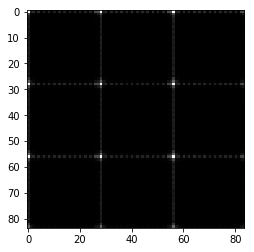

Epoch 1/2, step 110... Discriminator Loss: 1.6026... Generator Loss: 2.3816
Epoch 1/2, step 120... Discriminator Loss: 1.4961... Generator Loss: 1.4829
Epoch 1/2, step 130... Discriminator Loss: 1.4414... Generator Loss: 0.5883
Epoch 1/2, step 140... Discriminator Loss: 1.3890... Generator Loss: 1.2320
Epoch 1/2, step 150... Discriminator Loss: 1.7328... Generator Loss: 0.5357
Epoch 1/2, step 160... Discriminator Loss: 1.5016... Generator Loss: 1.7084
Epoch 1/2, step 170... Discriminator Loss: 1.3276... Generator Loss: 0.6928
Epoch 1/2, step 180... Discriminator Loss: 1.3080... Generator Loss: 0.7661
Epoch 1/2, step 190... Discriminator Loss: 1.2431... Generator Loss: 0.6837
Epoch 1/2, step 200... Discriminator Loss: 1.2126... Generator Loss: 1.1613


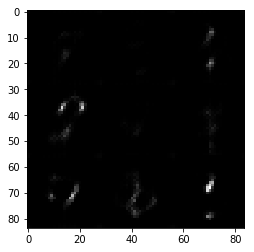

Epoch 1/2, step 210... Discriminator Loss: 1.2779... Generator Loss: 0.7787
Epoch 1/2, step 220... Discriminator Loss: 1.3820... Generator Loss: 1.3616
Epoch 1/2, step 230... Discriminator Loss: 1.5923... Generator Loss: 0.5463
Epoch 1/2, step 240... Discriminator Loss: 1.2237... Generator Loss: 0.6956
Epoch 1/2, step 250... Discriminator Loss: 1.6584... Generator Loss: 0.4581
Epoch 1/2, step 260... Discriminator Loss: 1.1460... Generator Loss: 0.8006
Epoch 1/2, step 270... Discriminator Loss: 1.3257... Generator Loss: 0.6160
Epoch 1/2, step 280... Discriminator Loss: 1.1042... Generator Loss: 1.0133
Epoch 1/2, step 290... Discriminator Loss: 1.2735... Generator Loss: 0.7196
Epoch 1/2, step 300... Discriminator Loss: 1.3188... Generator Loss: 0.8025


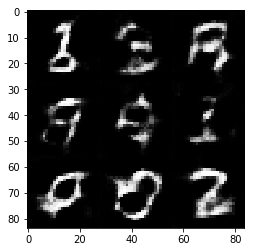

Epoch 1/2, step 310... Discriminator Loss: 1.3145... Generator Loss: 0.6785
Epoch 1/2, step 320... Discriminator Loss: 1.4120... Generator Loss: 3.1176
Epoch 1/2, step 330... Discriminator Loss: 1.1988... Generator Loss: 0.6890
Epoch 1/2, step 340... Discriminator Loss: 1.1078... Generator Loss: 1.4838
Epoch 1/2, step 350... Discriminator Loss: 0.9973... Generator Loss: 2.0700
Epoch 1/2, step 360... Discriminator Loss: 1.4221... Generator Loss: 1.4693
Epoch 1/2, step 370... Discriminator Loss: 1.3062... Generator Loss: 0.7134
Epoch 1/2, step 380... Discriminator Loss: 1.2449... Generator Loss: 0.6530
Epoch 1/2, step 390... Discriminator Loss: 1.1409... Generator Loss: 2.1604
Epoch 1/2, step 400... Discriminator Loss: 1.0171... Generator Loss: 1.3738


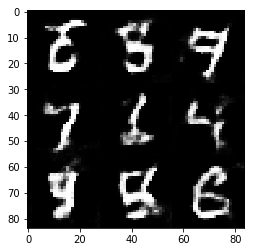

Epoch 1/2, step 410... Discriminator Loss: 0.8069... Generator Loss: 2.0441
Epoch 1/2, step 420... Discriminator Loss: 1.1538... Generator Loss: 0.6895
Epoch 1/2, step 430... Discriminator Loss: 0.6464... Generator Loss: 2.5608
Epoch 1/2, step 440... Discriminator Loss: 1.1406... Generator Loss: 1.0071
Epoch 1/2, step 450... Discriminator Loss: 1.0756... Generator Loss: 1.1516
Epoch 1/2, step 460... Discriminator Loss: 1.1012... Generator Loss: 1.2078
Epoch 1/2, step 470... Discriminator Loss: 1.1230... Generator Loss: 0.9280
Epoch 1/2, step 480... Discriminator Loss: 1.2098... Generator Loss: 1.0006
Epoch 1/2, step 490... Discriminator Loss: 1.2700... Generator Loss: 0.6901
Epoch 1/2, step 500... Discriminator Loss: 1.1710... Generator Loss: 0.9060


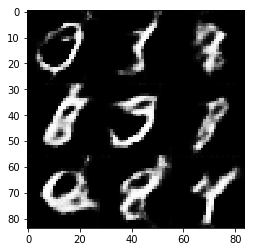

Epoch 1/2, step 510... Discriminator Loss: 1.5056... Generator Loss: 0.5113
Epoch 1/2, step 520... Discriminator Loss: 1.2043... Generator Loss: 0.7535
Epoch 1/2, step 530... Discriminator Loss: 1.1966... Generator Loss: 0.8588
Epoch 1/2, step 540... Discriminator Loss: 1.1766... Generator Loss: 0.9924
Epoch 1/2, step 550... Discriminator Loss: 1.2329... Generator Loss: 0.7949
Epoch 1/2, step 560... Discriminator Loss: 1.5512... Generator Loss: 0.5019
Epoch 1/2, step 570... Discriminator Loss: 1.1688... Generator Loss: 0.8486
Epoch 1/2, step 580... Discriminator Loss: 1.2949... Generator Loss: 0.7763
Epoch 1/2, step 590... Discriminator Loss: 1.3579... Generator Loss: 1.4249
Epoch 1/2, step 600... Discriminator Loss: 1.1724... Generator Loss: 0.8467


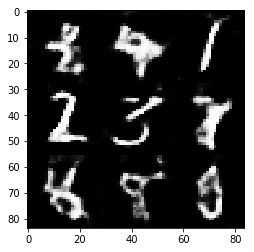

Epoch 1/2, step 610... Discriminator Loss: 1.2985... Generator Loss: 1.4403
Epoch 1/2, step 620... Discriminator Loss: 1.2392... Generator Loss: 0.7212
Epoch 1/2, step 630... Discriminator Loss: 1.2495... Generator Loss: 0.6709
Epoch 1/2, step 640... Discriminator Loss: 1.1490... Generator Loss: 0.9254
Epoch 1/2, step 650... Discriminator Loss: 1.2407... Generator Loss: 0.7952
Epoch 1/2, step 660... Discriminator Loss: 1.1424... Generator Loss: 0.8669
Epoch 1/2, step 670... Discriminator Loss: 1.4064... Generator Loss: 0.6619
Epoch 1/2, step 680... Discriminator Loss: 1.2622... Generator Loss: 1.0579
Epoch 1/2, step 690... Discriminator Loss: 1.3372... Generator Loss: 0.6055
Epoch 1/2, step 700... Discriminator Loss: 1.3640... Generator Loss: 0.5819


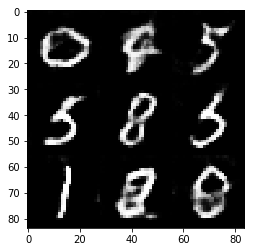

Epoch 1/2, step 710... Discriminator Loss: 1.4481... Generator Loss: 0.5328
Epoch 1/2, step 720... Discriminator Loss: 1.1307... Generator Loss: 0.8832
Epoch 1/2, step 730... Discriminator Loss: 1.2487... Generator Loss: 1.2852
Epoch 1/2, step 740... Discriminator Loss: 1.2063... Generator Loss: 0.7041
Epoch 1/2, step 750... Discriminator Loss: 1.1785... Generator Loss: 0.7772
Epoch 1/2, step 760... Discriminator Loss: 1.1838... Generator Loss: 1.0332
Epoch 1/2, step 770... Discriminator Loss: 1.4061... Generator Loss: 1.4934
Epoch 1/2, step 780... Discriminator Loss: 1.1857... Generator Loss: 0.8418
Epoch 1/2, step 790... Discriminator Loss: 1.4031... Generator Loss: 0.5616
Epoch 1/2, step 800... Discriminator Loss: 1.3199... Generator Loss: 0.7242


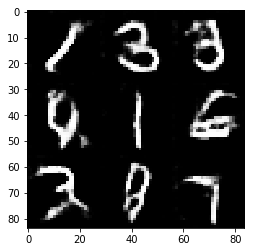

Epoch 1/2, step 810... Discriminator Loss: 1.4596... Generator Loss: 0.5345
Epoch 1/2, step 820... Discriminator Loss: 1.2219... Generator Loss: 0.8268
Epoch 1/2, step 830... Discriminator Loss: 1.3241... Generator Loss: 0.6069
Epoch 1/2, step 840... Discriminator Loss: 1.1956... Generator Loss: 0.8044
Epoch 1/2, step 850... Discriminator Loss: 1.3059... Generator Loss: 0.6379
Epoch 1/2, step 860... Discriminator Loss: 1.2525... Generator Loss: 1.4544
Epoch 1/2, step 870... Discriminator Loss: 1.4727... Generator Loss: 0.5275
Epoch 1/2, step 880... Discriminator Loss: 1.2446... Generator Loss: 0.6639
Epoch 1/2, step 890... Discriminator Loss: 1.2769... Generator Loss: 0.6817
Epoch 1/2, step 900... Discriminator Loss: 1.2035... Generator Loss: 1.0490


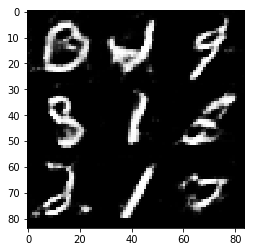

Epoch 1/2, step 910... Discriminator Loss: 1.3024... Generator Loss: 0.6495
Epoch 1/2, step 920... Discriminator Loss: 1.2009... Generator Loss: 0.7635
Epoch 1/2, step 930... Discriminator Loss: 1.3991... Generator Loss: 1.2113
Epoch 2/2, step 940... Discriminator Loss: 1.2354... Generator Loss: 0.7754
Epoch 2/2, step 950... Discriminator Loss: 1.2471... Generator Loss: 1.0567
Epoch 2/2, step 960... Discriminator Loss: 1.3232... Generator Loss: 0.6665
Epoch 2/2, step 970... Discriminator Loss: 1.3955... Generator Loss: 1.2599
Epoch 2/2, step 980... Discriminator Loss: 1.2253... Generator Loss: 0.8031
Epoch 2/2, step 990... Discriminator Loss: 1.1811... Generator Loss: 0.7757
Epoch 2/2, step 1000... Discriminator Loss: 1.2468... Generator Loss: 0.7563


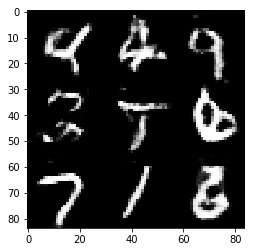

Epoch 2/2, step 1010... Discriminator Loss: 1.0953... Generator Loss: 1.0468
Epoch 2/2, step 1020... Discriminator Loss: 1.3347... Generator Loss: 1.1102
Epoch 2/2, step 1030... Discriminator Loss: 1.2746... Generator Loss: 0.8121
Epoch 2/2, step 1040... Discriminator Loss: 1.3390... Generator Loss: 0.7363
Epoch 2/2, step 1050... Discriminator Loss: 1.3456... Generator Loss: 0.5855
Epoch 2/2, step 1060... Discriminator Loss: 1.1715... Generator Loss: 0.9027
Epoch 2/2, step 1070... Discriminator Loss: 1.1133... Generator Loss: 0.9147
Epoch 2/2, step 1080... Discriminator Loss: 1.2513... Generator Loss: 0.8424
Epoch 2/2, step 1090... Discriminator Loss: 1.1462... Generator Loss: 0.7543
Epoch 2/2, step 1100... Discriminator Loss: 1.6362... Generator Loss: 0.4936


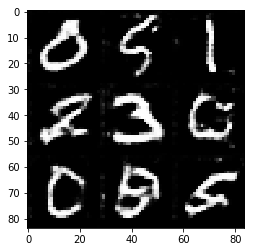

Epoch 2/2, step 1110... Discriminator Loss: 1.3023... Generator Loss: 0.6886
Epoch 2/2, step 1120... Discriminator Loss: 1.2611... Generator Loss: 0.7642
Epoch 2/2, step 1130... Discriminator Loss: 1.1808... Generator Loss: 1.0305
Epoch 2/2, step 1140... Discriminator Loss: 1.5033... Generator Loss: 0.5078
Epoch 2/2, step 1150... Discriminator Loss: 1.3259... Generator Loss: 0.6076
Epoch 2/2, step 1160... Discriminator Loss: 1.2259... Generator Loss: 0.7396
Epoch 2/2, step 1170... Discriminator Loss: 1.1217... Generator Loss: 1.1140
Epoch 2/2, step 1180... Discriminator Loss: 1.0675... Generator Loss: 0.9770
Epoch 2/2, step 1190... Discriminator Loss: 1.4401... Generator Loss: 0.5851
Epoch 2/2, step 1200... Discriminator Loss: 2.2179... Generator Loss: 1.6144


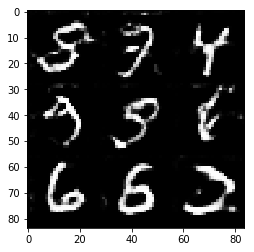

Epoch 2/2, step 1210... Discriminator Loss: 1.2305... Generator Loss: 0.9470
Epoch 2/2, step 1220... Discriminator Loss: 1.1386... Generator Loss: 0.9243
Epoch 2/2, step 1230... Discriminator Loss: 1.5845... Generator Loss: 0.4684
Epoch 2/2, step 1240... Discriminator Loss: 1.3205... Generator Loss: 0.8841
Epoch 2/2, step 1250... Discriminator Loss: 1.1696... Generator Loss: 0.8148
Epoch 2/2, step 1260... Discriminator Loss: 1.1746... Generator Loss: 0.6649
Epoch 2/2, step 1270... Discriminator Loss: 1.1959... Generator Loss: 0.8741
Epoch 2/2, step 1280... Discriminator Loss: 1.3275... Generator Loss: 1.3522
Epoch 2/2, step 1290... Discriminator Loss: 1.4451... Generator Loss: 0.5150
Epoch 2/2, step 1300... Discriminator Loss: 1.1782... Generator Loss: 0.9220


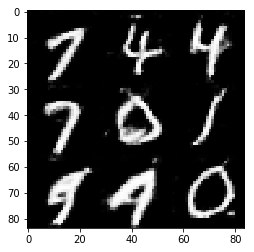

Epoch 2/2, step 1310... Discriminator Loss: 1.1054... Generator Loss: 0.9893
Epoch 2/2, step 1320... Discriminator Loss: 1.1187... Generator Loss: 1.4435
Epoch 2/2, step 1330... Discriminator Loss: 1.1724... Generator Loss: 0.8332
Epoch 2/2, step 1340... Discriminator Loss: 1.3539... Generator Loss: 0.5950
Epoch 2/2, step 1350... Discriminator Loss: 1.2210... Generator Loss: 1.3735
Epoch 2/2, step 1360... Discriminator Loss: 1.2420... Generator Loss: 0.7222
Epoch 2/2, step 1370... Discriminator Loss: 1.5225... Generator Loss: 0.5091
Epoch 2/2, step 1380... Discriminator Loss: 1.1676... Generator Loss: 0.8250
Epoch 2/2, step 1390... Discriminator Loss: 1.4706... Generator Loss: 0.5204
Epoch 2/2, step 1400... Discriminator Loss: 1.2423... Generator Loss: 0.9205


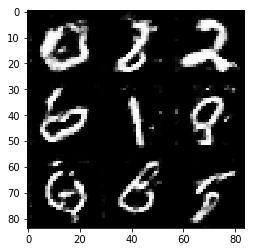

Epoch 2/2, step 1410... Discriminator Loss: 1.1043... Generator Loss: 1.1563
Epoch 2/2, step 1420... Discriminator Loss: 1.2145... Generator Loss: 1.0951
Epoch 2/2, step 1430... Discriminator Loss: 1.1465... Generator Loss: 0.7935
Epoch 2/2, step 1440... Discriminator Loss: 1.0876... Generator Loss: 0.7590
Epoch 2/2, step 1450... Discriminator Loss: 1.3318... Generator Loss: 0.6280
Epoch 2/2, step 1460... Discriminator Loss: 1.3472... Generator Loss: 0.6176
Epoch 2/2, step 1470... Discriminator Loss: 1.0987... Generator Loss: 0.8271
Epoch 2/2, step 1480... Discriminator Loss: 1.3892... Generator Loss: 0.5771
Epoch 2/2, step 1490... Discriminator Loss: 1.4933... Generator Loss: 0.5041
Epoch 2/2, step 1500... Discriminator Loss: 1.0793... Generator Loss: 0.8747


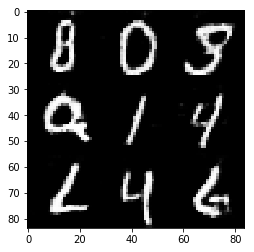

Epoch 2/2, step 1510... Discriminator Loss: 1.1897... Generator Loss: 0.7296
Epoch 2/2, step 1520... Discriminator Loss: 1.2043... Generator Loss: 1.4952
Epoch 2/2, step 1530... Discriminator Loss: 1.1121... Generator Loss: 0.9477
Epoch 2/2, step 1540... Discriminator Loss: 1.4412... Generator Loss: 0.5377
Epoch 2/2, step 1550... Discriminator Loss: 1.2214... Generator Loss: 0.6624
Epoch 2/2, step 1560... Discriminator Loss: 1.4260... Generator Loss: 0.5330
Epoch 2/2, step 1570... Discriminator Loss: 1.1537... Generator Loss: 1.0025
Epoch 2/2, step 1580... Discriminator Loss: 1.0258... Generator Loss: 1.2210
Epoch 2/2, step 1590... Discriminator Loss: 1.0503... Generator Loss: 0.8819
Epoch 2/2, step 1600... Discriminator Loss: 1.1869... Generator Loss: 0.7798


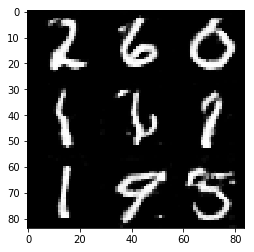

Epoch 2/2, step 1610... Discriminator Loss: 1.5606... Generator Loss: 1.8130
Epoch 2/2, step 1620... Discriminator Loss: 1.1291... Generator Loss: 1.3973
Epoch 2/2, step 1630... Discriminator Loss: 1.0125... Generator Loss: 0.9939
Epoch 2/2, step 1640... Discriminator Loss: 1.2466... Generator Loss: 1.1930
Epoch 2/2, step 1650... Discriminator Loss: 1.1529... Generator Loss: 0.8621
Epoch 2/2, step 1660... Discriminator Loss: 1.1712... Generator Loss: 1.3065
Epoch 2/2, step 1670... Discriminator Loss: 1.0127... Generator Loss: 1.1028
Epoch 2/2, step 1680... Discriminator Loss: 1.0588... Generator Loss: 0.9282
Epoch 2/2, step 1690... Discriminator Loss: 1.1399... Generator Loss: 0.7077
Epoch 2/2, step 1700... Discriminator Loss: 1.0956... Generator Loss: 1.1671


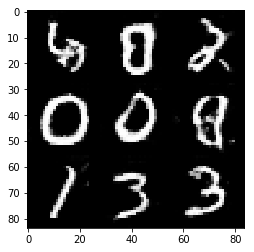

Epoch 2/2, step 1710... Discriminator Loss: 1.0536... Generator Loss: 1.4634
Epoch 2/2, step 1720... Discriminator Loss: 1.2438... Generator Loss: 1.8311
Epoch 2/2, step 1730... Discriminator Loss: 1.0717... Generator Loss: 1.0630
Epoch 2/2, step 1740... Discriminator Loss: 1.1291... Generator Loss: 0.7558
Epoch 2/2, step 1750... Discriminator Loss: 1.0197... Generator Loss: 0.9113
Epoch 2/2, step 1760... Discriminator Loss: 1.0802... Generator Loss: 1.9000
Epoch 2/2, step 1770... Discriminator Loss: 1.4385... Generator Loss: 0.5542
Epoch 2/2, step 1780... Discriminator Loss: 1.2934... Generator Loss: 0.6199
Epoch 2/2, step 1790... Discriminator Loss: 1.1917... Generator Loss: 1.3940
Epoch 2/2, step 1800... Discriminator Loss: 1.1508... Generator Loss: 0.7664


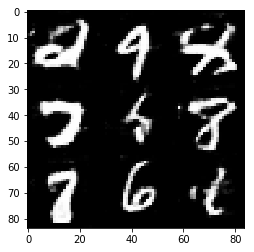

Epoch 2/2, step 1810... Discriminator Loss: 1.2635... Generator Loss: 0.6906
Epoch 2/2, step 1820... Discriminator Loss: 1.1762... Generator Loss: 0.9660
Epoch 2/2, step 1830... Discriminator Loss: 1.2857... Generator Loss: 0.6377
Epoch 2/2, step 1840... Discriminator Loss: 1.3432... Generator Loss: 0.5675
Epoch 2/2, step 1850... Discriminator Loss: 0.9716... Generator Loss: 0.9630
Epoch 2/2, step 1860... Discriminator Loss: 1.2488... Generator Loss: 0.6921
Epoch 2/2, step 1870... Discriminator Loss: 1.1961... Generator Loss: 1.4595


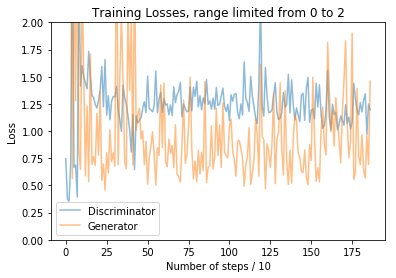

In [56]:
# Slightly modified from the values in the Radford, Metz and Chintala paper https://arxiv.org/pdf/1511.06434.pdf
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

The x axis on the graph above shows tens of steps. Though the loss of both the Generator and Discriminator are quite variable the graph shows that the Generator loss is generally lower than the Discriminator loss. This suggests the model is working reasonably well. Some of the generated digits in the later inferences (though not all of them) do resemble handwritten digits, e.g. 6, 8, 9 are visible in the last set.

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1, step 10... Discriminator Loss: 0.4005... Generator Loss: 3.6656
Epoch 1/1, step 20... Discriminator Loss: 0.4234... Generator Loss: 6.7526
Epoch 1/1, step 30... Discriminator Loss: 0.3799... Generator Loss: 3.0104
Epoch 1/1, step 40... Discriminator Loss: 0.3683... Generator Loss: 3.3364
Epoch 1/1, step 50... Discriminator Loss: 0.5447... Generator Loss: 4.6447
Epoch 1/1, step 60... Discriminator Loss: 1.1934... Generator Loss: 0.9841
Epoch 1/1, step 70... Discriminator Loss: 1.3641... Generator Loss: 0.8489
Epoch 1/1, step 80... Discriminator Loss: 0.3667... Generator Loss: 3.6028
Epoch 1/1, step 90... Discriminator Loss: 1.9211... Generator Loss: 2.5415
Epoch 1/1, step 100... Discriminator Loss: 0.8302... Generator Loss: 3.2228


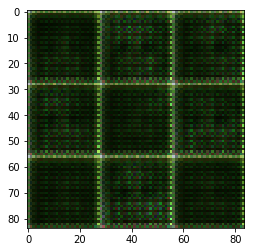

Epoch 1/1, step 110... Discriminator Loss: 1.3599... Generator Loss: 2.3250
Epoch 1/1, step 120... Discriminator Loss: 1.1567... Generator Loss: 0.7252
Epoch 1/1, step 130... Discriminator Loss: 1.1240... Generator Loss: 0.7571
Epoch 1/1, step 140... Discriminator Loss: 1.3116... Generator Loss: 0.5891
Epoch 1/1, step 150... Discriminator Loss: 0.5805... Generator Loss: 3.6681
Epoch 1/1, step 160... Discriminator Loss: 0.6867... Generator Loss: 1.3292
Epoch 1/1, step 170... Discriminator Loss: 0.5262... Generator Loss: 2.9377
Epoch 1/1, step 180... Discriminator Loss: 0.4658... Generator Loss: 4.4866
Epoch 1/1, step 190... Discriminator Loss: 2.1338... Generator Loss: 0.4229
Epoch 1/1, step 200... Discriminator Loss: 0.6185... Generator Loss: 1.5604


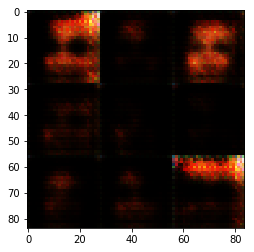

Epoch 1/1, step 210... Discriminator Loss: 0.4063... Generator Loss: 4.4038
Epoch 1/1, step 220... Discriminator Loss: 0.9005... Generator Loss: 5.9670
Epoch 1/1, step 230... Discriminator Loss: 0.7664... Generator Loss: 1.2706
Epoch 1/1, step 240... Discriminator Loss: 1.0490... Generator Loss: 1.0894
Epoch 1/1, step 250... Discriminator Loss: 1.5564... Generator Loss: 0.5463
Epoch 1/1, step 260... Discriminator Loss: 0.6530... Generator Loss: 2.2389
Epoch 1/1, step 270... Discriminator Loss: 1.2045... Generator Loss: 0.6941
Epoch 1/1, step 280... Discriminator Loss: 0.7488... Generator Loss: 1.6737
Epoch 1/1, step 290... Discriminator Loss: 0.9224... Generator Loss: 1.3573
Epoch 1/1, step 300... Discriminator Loss: 1.6197... Generator Loss: 0.4906


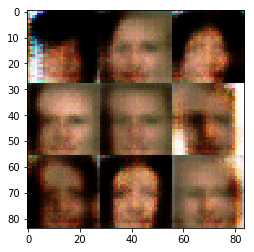

Epoch 1/1, step 310... Discriminator Loss: 0.9574... Generator Loss: 1.2715
Epoch 1/1, step 320... Discriminator Loss: 1.0546... Generator Loss: 0.9104
Epoch 1/1, step 330... Discriminator Loss: 1.2883... Generator Loss: 0.9024
Epoch 1/1, step 340... Discriminator Loss: 1.4005... Generator Loss: 0.7977
Epoch 1/1, step 350... Discriminator Loss: 1.1940... Generator Loss: 0.8399
Epoch 1/1, step 360... Discriminator Loss: 1.1860... Generator Loss: 0.6850
Epoch 1/1, step 370... Discriminator Loss: 1.1596... Generator Loss: 0.8231
Epoch 1/1, step 380... Discriminator Loss: 1.2401... Generator Loss: 0.6877
Epoch 1/1, step 390... Discriminator Loss: 1.4975... Generator Loss: 0.6308
Epoch 1/1, step 400... Discriminator Loss: 1.1254... Generator Loss: 1.3955


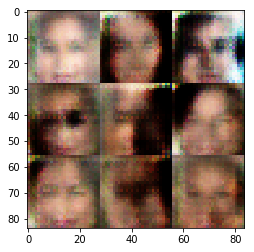

Epoch 1/1, step 410... Discriminator Loss: 1.2958... Generator Loss: 0.7187
Epoch 1/1, step 420... Discriminator Loss: 1.1110... Generator Loss: 1.2170
Epoch 1/1, step 430... Discriminator Loss: 1.4766... Generator Loss: 1.5934
Epoch 1/1, step 440... Discriminator Loss: 1.1177... Generator Loss: 0.8574
Epoch 1/1, step 450... Discriminator Loss: 1.8511... Generator Loss: 0.3989
Epoch 1/1, step 460... Discriminator Loss: 1.5574... Generator Loss: 1.3360
Epoch 1/1, step 470... Discriminator Loss: 1.1316... Generator Loss: 1.2608
Epoch 1/1, step 480... Discriminator Loss: 1.6526... Generator Loss: 0.4599
Epoch 1/1, step 490... Discriminator Loss: 1.0405... Generator Loss: 0.8352
Epoch 1/1, step 500... Discriminator Loss: 1.3699... Generator Loss: 0.6411


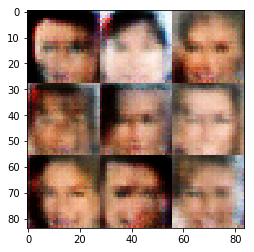

Epoch 1/1, step 510... Discriminator Loss: 1.3660... Generator Loss: 0.7368
Epoch 1/1, step 520... Discriminator Loss: 1.2666... Generator Loss: 0.9897
Epoch 1/1, step 530... Discriminator Loss: 1.3634... Generator Loss: 1.0366
Epoch 1/1, step 540... Discriminator Loss: 1.4695... Generator Loss: 1.0111
Epoch 1/1, step 550... Discriminator Loss: 1.0263... Generator Loss: 1.3002
Epoch 1/1, step 560... Discriminator Loss: 1.0833... Generator Loss: 1.7761
Epoch 1/1, step 570... Discriminator Loss: 0.9929... Generator Loss: 0.8838
Epoch 1/1, step 580... Discriminator Loss: 1.3408... Generator Loss: 0.7832
Epoch 1/1, step 590... Discriminator Loss: 1.3505... Generator Loss: 0.8581
Epoch 1/1, step 600... Discriminator Loss: 1.0743... Generator Loss: 0.8770


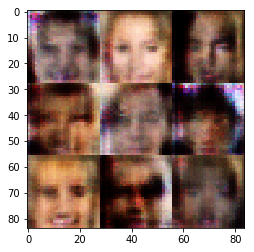

Epoch 1/1, step 610... Discriminator Loss: 1.4966... Generator Loss: 0.6078
Epoch 1/1, step 620... Discriminator Loss: 1.2875... Generator Loss: 0.6093
Epoch 1/1, step 630... Discriminator Loss: 1.3824... Generator Loss: 0.6368
Epoch 1/1, step 640... Discriminator Loss: 1.1808... Generator Loss: 0.8695
Epoch 1/1, step 650... Discriminator Loss: 1.5979... Generator Loss: 0.4649
Epoch 1/1, step 660... Discriminator Loss: 1.2611... Generator Loss: 0.6738
Epoch 1/1, step 670... Discriminator Loss: 1.3288... Generator Loss: 1.3696
Epoch 1/1, step 680... Discriminator Loss: 1.4234... Generator Loss: 0.5716
Epoch 1/1, step 690... Discriminator Loss: 1.1225... Generator Loss: 1.2217
Epoch 1/1, step 700... Discriminator Loss: 0.9445... Generator Loss: 1.2350


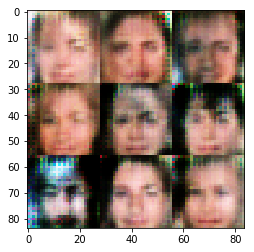

Epoch 1/1, step 710... Discriminator Loss: 1.3780... Generator Loss: 0.7361
Epoch 1/1, step 720... Discriminator Loss: 1.4277... Generator Loss: 0.6904
Epoch 1/1, step 730... Discriminator Loss: 1.4120... Generator Loss: 0.6212
Epoch 1/1, step 740... Discriminator Loss: 1.1951... Generator Loss: 1.2025
Epoch 1/1, step 750... Discriminator Loss: 1.0312... Generator Loss: 0.9289
Epoch 1/1, step 760... Discriminator Loss: 1.2347... Generator Loss: 0.6528
Epoch 1/1, step 770... Discriminator Loss: 0.7579... Generator Loss: 1.6076
Epoch 1/1, step 780... Discriminator Loss: 1.0611... Generator Loss: 2.1895
Epoch 1/1, step 790... Discriminator Loss: 1.2156... Generator Loss: 1.2843
Epoch 1/1, step 800... Discriminator Loss: 0.7467... Generator Loss: 1.6527


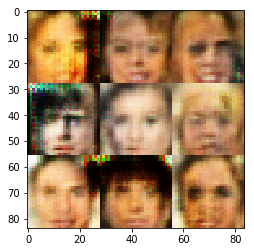

Epoch 1/1, step 810... Discriminator Loss: 1.0763... Generator Loss: 0.8374
Epoch 1/1, step 820... Discriminator Loss: 1.4972... Generator Loss: 0.6751
Epoch 1/1, step 830... Discriminator Loss: 1.8861... Generator Loss: 2.0226
Epoch 1/1, step 840... Discriminator Loss: 0.7976... Generator Loss: 1.1538
Epoch 1/1, step 850... Discriminator Loss: 1.2193... Generator Loss: 0.9101
Epoch 1/1, step 860... Discriminator Loss: 1.3218... Generator Loss: 1.0793
Epoch 1/1, step 870... Discriminator Loss: 1.2760... Generator Loss: 0.6566
Epoch 1/1, step 880... Discriminator Loss: 1.2514... Generator Loss: 0.7189
Epoch 1/1, step 890... Discriminator Loss: 1.5647... Generator Loss: 0.4862
Epoch 1/1, step 900... Discriminator Loss: 0.6380... Generator Loss: 1.6412


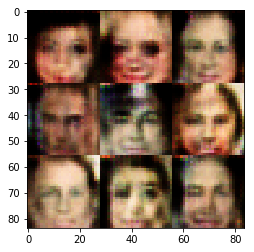

Epoch 1/1, step 910... Discriminator Loss: 1.1056... Generator Loss: 0.9815
Epoch 1/1, step 920... Discriminator Loss: 1.3652... Generator Loss: 0.6344
Epoch 1/1, step 930... Discriminator Loss: 1.1807... Generator Loss: 0.7949
Epoch 1/1, step 940... Discriminator Loss: 0.9693... Generator Loss: 1.1614
Epoch 1/1, step 950... Discriminator Loss: 1.3759... Generator Loss: 0.5634
Epoch 1/1, step 960... Discriminator Loss: 1.5501... Generator Loss: 0.6499
Epoch 1/1, step 970... Discriminator Loss: 1.3929... Generator Loss: 0.8055
Epoch 1/1, step 980... Discriminator Loss: 1.1798... Generator Loss: 0.9727
Epoch 1/1, step 990... Discriminator Loss: 1.0050... Generator Loss: 1.0135
Epoch 1/1, step 1000... Discriminator Loss: 0.9247... Generator Loss: 0.9064


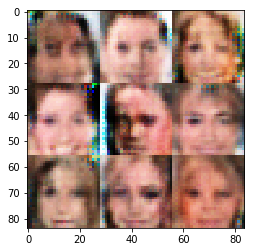

Epoch 1/1, step 1010... Discriminator Loss: 1.2511... Generator Loss: 0.6780
Epoch 1/1, step 1020... Discriminator Loss: 1.2432... Generator Loss: 1.0103
Epoch 1/1, step 1030... Discriminator Loss: 1.4681... Generator Loss: 0.6198
Epoch 1/1, step 1040... Discriminator Loss: 1.1876... Generator Loss: 1.5370
Epoch 1/1, step 1050... Discriminator Loss: 1.1614... Generator Loss: 0.9319
Epoch 1/1, step 1060... Discriminator Loss: 1.1022... Generator Loss: 0.7711
Epoch 1/1, step 1070... Discriminator Loss: 1.2636... Generator Loss: 0.9625
Epoch 1/1, step 1080... Discriminator Loss: 1.0993... Generator Loss: 0.8242
Epoch 1/1, step 1090... Discriminator Loss: 1.0322... Generator Loss: 0.9849
Epoch 1/1, step 1100... Discriminator Loss: 1.4044... Generator Loss: 0.6637


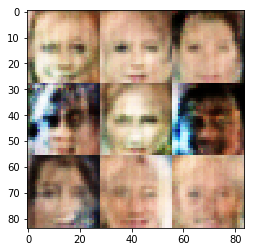

Epoch 1/1, step 1110... Discriminator Loss: 1.6552... Generator Loss: 0.5216
Epoch 1/1, step 1120... Discriminator Loss: 1.0395... Generator Loss: 1.1739
Epoch 1/1, step 1130... Discriminator Loss: 1.0918... Generator Loss: 0.8830
Epoch 1/1, step 1140... Discriminator Loss: 1.3814... Generator Loss: 0.7206
Epoch 1/1, step 1150... Discriminator Loss: 1.3638... Generator Loss: 0.6719
Epoch 1/1, step 1160... Discriminator Loss: 1.2818... Generator Loss: 0.6120
Epoch 1/1, step 1170... Discriminator Loss: 1.4424... Generator Loss: 0.5389
Epoch 1/1, step 1180... Discriminator Loss: 1.3815... Generator Loss: 1.7159
Epoch 1/1, step 1190... Discriminator Loss: 1.4059... Generator Loss: 0.5423
Epoch 1/1, step 1200... Discriminator Loss: 1.1240... Generator Loss: 0.9703


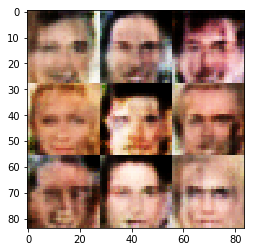

Epoch 1/1, step 1210... Discriminator Loss: 1.1911... Generator Loss: 0.9091
Epoch 1/1, step 1220... Discriminator Loss: 1.6376... Generator Loss: 1.5273
Epoch 1/1, step 1230... Discriminator Loss: 1.2348... Generator Loss: 0.9137
Epoch 1/1, step 1240... Discriminator Loss: 2.0507... Generator Loss: 2.0521
Epoch 1/1, step 1250... Discriminator Loss: 0.9622... Generator Loss: 1.0355
Epoch 1/1, step 1260... Discriminator Loss: 0.9575... Generator Loss: 1.2389
Epoch 1/1, step 1270... Discriminator Loss: 1.1575... Generator Loss: 0.8897
Epoch 1/1, step 1280... Discriminator Loss: 1.4598... Generator Loss: 0.7536
Epoch 1/1, step 1290... Discriminator Loss: 1.0408... Generator Loss: 0.8706
Epoch 1/1, step 1300... Discriminator Loss: 1.3340... Generator Loss: 1.3247


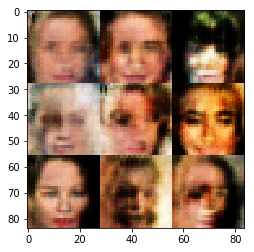

Epoch 1/1, step 1310... Discriminator Loss: 1.3097... Generator Loss: 0.8139
Epoch 1/1, step 1320... Discriminator Loss: 2.1080... Generator Loss: 0.3607
Epoch 1/1, step 1330... Discriminator Loss: 1.3537... Generator Loss: 0.5725
Epoch 1/1, step 1340... Discriminator Loss: 1.2646... Generator Loss: 0.8486
Epoch 1/1, step 1350... Discriminator Loss: 1.3031... Generator Loss: 0.6129
Epoch 1/1, step 1360... Discriminator Loss: 0.9838... Generator Loss: 1.2106
Epoch 1/1, step 1370... Discriminator Loss: 0.7557... Generator Loss: 2.0631
Epoch 1/1, step 1380... Discriminator Loss: 1.5030... Generator Loss: 0.5785
Epoch 1/1, step 1390... Discriminator Loss: 1.5285... Generator Loss: 1.2812
Epoch 1/1, step 1400... Discriminator Loss: 1.3113... Generator Loss: 0.6696


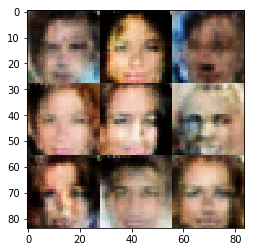

Epoch 1/1, step 1410... Discriminator Loss: 1.3419... Generator Loss: 0.5906
Epoch 1/1, step 1420... Discriminator Loss: 1.3081... Generator Loss: 1.4366
Epoch 1/1, step 1430... Discriminator Loss: 1.0978... Generator Loss: 1.1912
Epoch 1/1, step 1440... Discriminator Loss: 1.2234... Generator Loss: 1.5557
Epoch 1/1, step 1450... Discriminator Loss: 1.3744... Generator Loss: 0.7906
Epoch 1/1, step 1460... Discriminator Loss: 1.3510... Generator Loss: 0.7732
Epoch 1/1, step 1470... Discriminator Loss: 1.2776... Generator Loss: 0.6482
Epoch 1/1, step 1480... Discriminator Loss: 0.9617... Generator Loss: 1.4379
Epoch 1/1, step 1490... Discriminator Loss: 1.1794... Generator Loss: 0.6859
Epoch 1/1, step 1500... Discriminator Loss: 0.9601... Generator Loss: 1.0077


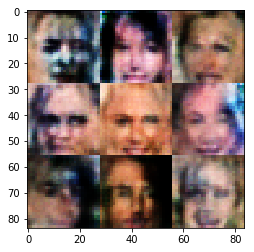

Epoch 1/1, step 1510... Discriminator Loss: 1.3865... Generator Loss: 1.2709
Epoch 1/1, step 1520... Discriminator Loss: 1.2549... Generator Loss: 0.6493
Epoch 1/1, step 1530... Discriminator Loss: 1.2435... Generator Loss: 0.6949
Epoch 1/1, step 1540... Discriminator Loss: 1.2598... Generator Loss: 0.6327
Epoch 1/1, step 1550... Discriminator Loss: 1.3979... Generator Loss: 1.3104
Epoch 1/1, step 1560... Discriminator Loss: 1.2135... Generator Loss: 1.1357
Epoch 1/1, step 1570... Discriminator Loss: 1.5278... Generator Loss: 0.5976
Epoch 1/1, step 1580... Discriminator Loss: 1.2109... Generator Loss: 0.8558
Epoch 1/1, step 1590... Discriminator Loss: 1.4545... Generator Loss: 1.1779
Epoch 1/1, step 1600... Discriminator Loss: 1.3272... Generator Loss: 0.9329


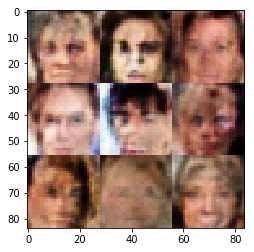

Epoch 1/1, step 1610... Discriminator Loss: 1.2177... Generator Loss: 1.0924
Epoch 1/1, step 1620... Discriminator Loss: 1.4615... Generator Loss: 0.9262
Epoch 1/1, step 1630... Discriminator Loss: 1.2046... Generator Loss: 0.7094
Epoch 1/1, step 1640... Discriminator Loss: 1.5668... Generator Loss: 0.5153
Epoch 1/1, step 1650... Discriminator Loss: 1.4328... Generator Loss: 0.8218
Epoch 1/1, step 1660... Discriminator Loss: 0.9200... Generator Loss: 1.2572
Epoch 1/1, step 1670... Discriminator Loss: 1.0730... Generator Loss: 0.9142
Epoch 1/1, step 1680... Discriminator Loss: 1.4585... Generator Loss: 0.7194
Epoch 1/1, step 1690... Discriminator Loss: 1.3179... Generator Loss: 0.7660
Epoch 1/1, step 1700... Discriminator Loss: 1.2225... Generator Loss: 1.0312


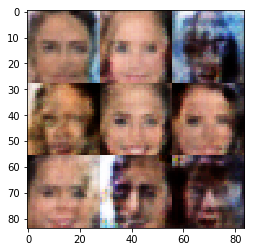

Epoch 1/1, step 1710... Discriminator Loss: 1.3795... Generator Loss: 0.9196
Epoch 1/1, step 1720... Discriminator Loss: 1.3436... Generator Loss: 0.8411
Epoch 1/1, step 1730... Discriminator Loss: 1.4509... Generator Loss: 0.5026
Epoch 1/1, step 1740... Discriminator Loss: 0.9278... Generator Loss: 0.9040
Epoch 1/1, step 1750... Discriminator Loss: 1.6054... Generator Loss: 0.5523
Epoch 1/1, step 1760... Discriminator Loss: 1.3056... Generator Loss: 0.7556
Epoch 1/1, step 1770... Discriminator Loss: 1.3998... Generator Loss: 0.8814
Epoch 1/1, step 1780... Discriminator Loss: 1.4331... Generator Loss: 1.0983
Epoch 1/1, step 1790... Discriminator Loss: 1.3740... Generator Loss: 0.7229
Epoch 1/1, step 1800... Discriminator Loss: 1.3822... Generator Loss: 0.8710


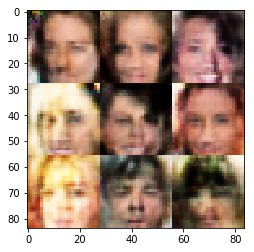

Epoch 1/1, step 1810... Discriminator Loss: 0.5448... Generator Loss: 2.4344
Epoch 1/1, step 1820... Discriminator Loss: 0.8354... Generator Loss: 1.0768
Epoch 1/1, step 1830... Discriminator Loss: 2.0087... Generator Loss: 2.0493
Epoch 1/1, step 1840... Discriminator Loss: 1.4555... Generator Loss: 0.7769
Epoch 1/1, step 1850... Discriminator Loss: 1.2384... Generator Loss: 0.8303
Epoch 1/1, step 1860... Discriminator Loss: 1.3237... Generator Loss: 0.7819
Epoch 1/1, step 1870... Discriminator Loss: 1.3439... Generator Loss: 0.7597
Epoch 1/1, step 1880... Discriminator Loss: 1.4529... Generator Loss: 0.7196
Epoch 1/1, step 1890... Discriminator Loss: 1.3942... Generator Loss: 0.7871
Epoch 1/1, step 1900... Discriminator Loss: 1.5080... Generator Loss: 0.7213


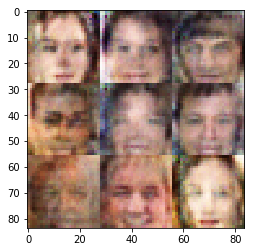

Epoch 1/1, step 1910... Discriminator Loss: 1.5167... Generator Loss: 0.6830
Epoch 1/1, step 1920... Discriminator Loss: 1.4671... Generator Loss: 0.6443
Epoch 1/1, step 1930... Discriminator Loss: 1.4991... Generator Loss: 0.6809
Epoch 1/1, step 1940... Discriminator Loss: 1.4160... Generator Loss: 0.7261
Epoch 1/1, step 1950... Discriminator Loss: 1.2999... Generator Loss: 0.7498
Epoch 1/1, step 1960... Discriminator Loss: 1.5676... Generator Loss: 0.6701
Epoch 1/1, step 1970... Discriminator Loss: 1.2964... Generator Loss: 0.8047
Epoch 1/1, step 1980... Discriminator Loss: 1.2766... Generator Loss: 0.7918
Epoch 1/1, step 1990... Discriminator Loss: 1.4088... Generator Loss: 0.7831
Epoch 1/1, step 2000... Discriminator Loss: 1.5121... Generator Loss: 0.6363


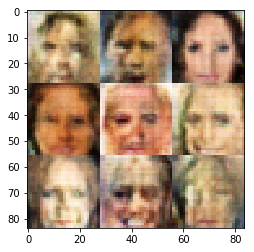

Epoch 1/1, step 2010... Discriminator Loss: 1.1903... Generator Loss: 0.8266
Epoch 1/1, step 2020... Discriminator Loss: 1.2769... Generator Loss: 0.8520
Epoch 1/1, step 2030... Discriminator Loss: 1.3363... Generator Loss: 0.7129
Epoch 1/1, step 2040... Discriminator Loss: 1.2252... Generator Loss: 0.8233
Epoch 1/1, step 2050... Discriminator Loss: 1.4908... Generator Loss: 0.6029
Epoch 1/1, step 2060... Discriminator Loss: 1.5070... Generator Loss: 0.5928
Epoch 1/1, step 2070... Discriminator Loss: 1.5728... Generator Loss: 0.4725
Epoch 1/1, step 2080... Discriminator Loss: 1.1315... Generator Loss: 0.8268
Epoch 1/1, step 2090... Discriminator Loss: 1.4194... Generator Loss: 0.5893
Epoch 1/1, step 2100... Discriminator Loss: 1.2023... Generator Loss: 0.8809


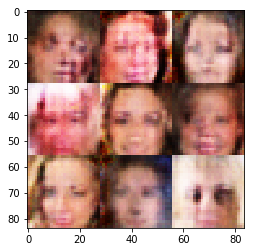

Epoch 1/1, step 2110... Discriminator Loss: 1.3544... Generator Loss: 0.7193
Epoch 1/1, step 2120... Discriminator Loss: 1.4537... Generator Loss: 0.5812
Epoch 1/1, step 2130... Discriminator Loss: 1.3592... Generator Loss: 0.6887
Epoch 1/1, step 2140... Discriminator Loss: 1.3255... Generator Loss: 0.8149
Epoch 1/1, step 2150... Discriminator Loss: 1.5398... Generator Loss: 0.5560
Epoch 1/1, step 2160... Discriminator Loss: 1.1787... Generator Loss: 0.8371
Epoch 1/1, step 2170... Discriminator Loss: 1.1175... Generator Loss: 0.9073
Epoch 1/1, step 2180... Discriminator Loss: 1.5015... Generator Loss: 0.9528
Epoch 1/1, step 2190... Discriminator Loss: 1.3441... Generator Loss: 0.7331
Epoch 1/1, step 2200... Discriminator Loss: 1.3947... Generator Loss: 0.7683


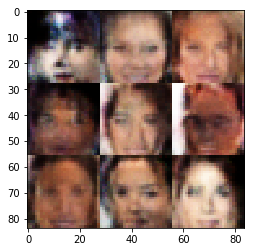

Epoch 1/1, step 2210... Discriminator Loss: 1.6025... Generator Loss: 0.8069
Epoch 1/1, step 2220... Discriminator Loss: 1.3725... Generator Loss: 0.6626
Epoch 1/1, step 2230... Discriminator Loss: 1.3544... Generator Loss: 0.6906
Epoch 1/1, step 2240... Discriminator Loss: 1.4431... Generator Loss: 0.6686
Epoch 1/1, step 2250... Discriminator Loss: 1.2433... Generator Loss: 0.8244
Epoch 1/1, step 2260... Discriminator Loss: 1.4272... Generator Loss: 0.6854
Epoch 1/1, step 2270... Discriminator Loss: 1.3506... Generator Loss: 0.8415
Epoch 1/1, step 2280... Discriminator Loss: 1.4871... Generator Loss: 0.6711
Epoch 1/1, step 2290... Discriminator Loss: 1.4308... Generator Loss: 0.7354
Epoch 1/1, step 2300... Discriminator Loss: 1.4773... Generator Loss: 0.6016


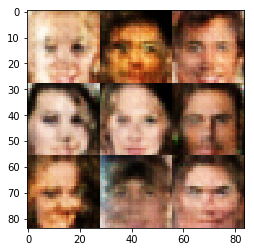

Epoch 1/1, step 2310... Discriminator Loss: 1.3840... Generator Loss: 0.8236
Epoch 1/1, step 2320... Discriminator Loss: 1.4294... Generator Loss: 0.6508
Epoch 1/1, step 2330... Discriminator Loss: 1.4032... Generator Loss: 0.7468
Epoch 1/1, step 2340... Discriminator Loss: 1.1947... Generator Loss: 0.9249
Epoch 1/1, step 2350... Discriminator Loss: 1.5096... Generator Loss: 0.6084
Epoch 1/1, step 2360... Discriminator Loss: 1.3197... Generator Loss: 0.6872
Epoch 1/1, step 2370... Discriminator Loss: 1.4844... Generator Loss: 0.5398
Epoch 1/1, step 2380... Discriminator Loss: 1.3053... Generator Loss: 0.7486
Epoch 1/1, step 2390... Discriminator Loss: 1.3832... Generator Loss: 0.6676
Epoch 1/1, step 2400... Discriminator Loss: 1.3225... Generator Loss: 0.9506


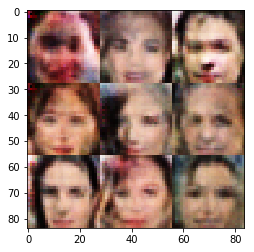

Epoch 1/1, step 2410... Discriminator Loss: 1.5126... Generator Loss: 0.5627
Epoch 1/1, step 2420... Discriminator Loss: 1.3659... Generator Loss: 0.7986
Epoch 1/1, step 2430... Discriminator Loss: 1.5151... Generator Loss: 0.8171
Epoch 1/1, step 2440... Discriminator Loss: 1.3229... Generator Loss: 0.8340
Epoch 1/1, step 2450... Discriminator Loss: 1.3141... Generator Loss: 0.7200
Epoch 1/1, step 2460... Discriminator Loss: 1.4992... Generator Loss: 0.7061
Epoch 1/1, step 2470... Discriminator Loss: 1.2831... Generator Loss: 0.7820
Epoch 1/1, step 2480... Discriminator Loss: 1.1819... Generator Loss: 0.7658
Epoch 1/1, step 2490... Discriminator Loss: 1.2986... Generator Loss: 0.8684
Epoch 1/1, step 2500... Discriminator Loss: 1.4170... Generator Loss: 0.7208


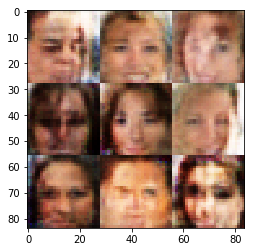

Epoch 1/1, step 2510... Discriminator Loss: 1.3365... Generator Loss: 0.7913
Epoch 1/1, step 2520... Discriminator Loss: 1.1949... Generator Loss: 0.8903
Epoch 1/1, step 2530... Discriminator Loss: 1.2807... Generator Loss: 0.7814
Epoch 1/1, step 2540... Discriminator Loss: 1.3740... Generator Loss: 0.7275
Epoch 1/1, step 2550... Discriminator Loss: 1.3289... Generator Loss: 0.7374
Epoch 1/1, step 2560... Discriminator Loss: 1.3695... Generator Loss: 0.7507
Epoch 1/1, step 2570... Discriminator Loss: 1.3886... Generator Loss: 0.7076
Epoch 1/1, step 2580... Discriminator Loss: 1.3984... Generator Loss: 0.6572
Epoch 1/1, step 2590... Discriminator Loss: 1.2936... Generator Loss: 0.8147
Epoch 1/1, step 2600... Discriminator Loss: 1.2801... Generator Loss: 0.8468


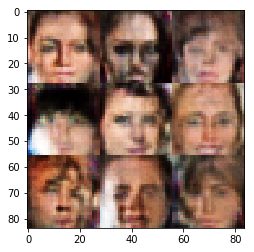

Epoch 1/1, step 2610... Discriminator Loss: 1.3766... Generator Loss: 0.7175
Epoch 1/1, step 2620... Discriminator Loss: 1.4703... Generator Loss: 0.7098
Epoch 1/1, step 2630... Discriminator Loss: 1.4851... Generator Loss: 0.6525
Epoch 1/1, step 2640... Discriminator Loss: 1.3793... Generator Loss: 0.7901
Epoch 1/1, step 2650... Discriminator Loss: 1.4505... Generator Loss: 0.6239
Epoch 1/1, step 2660... Discriminator Loss: 1.3963... Generator Loss: 0.7048
Epoch 1/1, step 2670... Discriminator Loss: 1.3971... Generator Loss: 0.6797
Epoch 1/1, step 2680... Discriminator Loss: 1.4390... Generator Loss: 0.7770
Epoch 1/1, step 2690... Discriminator Loss: 1.4568... Generator Loss: 0.7223
Epoch 1/1, step 2700... Discriminator Loss: 1.3597... Generator Loss: 0.8366


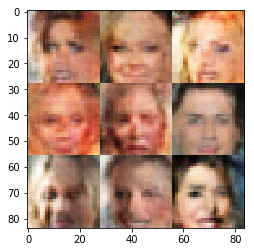

Epoch 1/1, step 2710... Discriminator Loss: 1.5195... Generator Loss: 0.6925
Epoch 1/1, step 2720... Discriminator Loss: 1.3965... Generator Loss: 0.7109
Epoch 1/1, step 2730... Discriminator Loss: 1.3253... Generator Loss: 0.8149
Epoch 1/1, step 2740... Discriminator Loss: 1.3707... Generator Loss: 0.7648
Epoch 1/1, step 2750... Discriminator Loss: 1.4044... Generator Loss: 0.6793
Epoch 1/1, step 2760... Discriminator Loss: 1.5207... Generator Loss: 0.7845
Epoch 1/1, step 2770... Discriminator Loss: 1.3814... Generator Loss: 0.7144
Epoch 1/1, step 2780... Discriminator Loss: 1.4121... Generator Loss: 0.7122
Epoch 1/1, step 2790... Discriminator Loss: 1.4142... Generator Loss: 0.6305
Epoch 1/1, step 2800... Discriminator Loss: 1.4645... Generator Loss: 0.6426


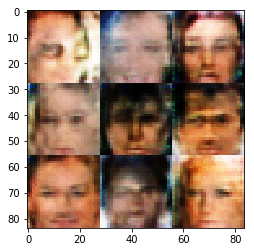

Epoch 1/1, step 2810... Discriminator Loss: 1.1951... Generator Loss: 0.9258
Epoch 1/1, step 2820... Discriminator Loss: 1.4388... Generator Loss: 0.6840
Epoch 1/1, step 2830... Discriminator Loss: 1.2751... Generator Loss: 0.8102
Epoch 1/1, step 2840... Discriminator Loss: 1.3650... Generator Loss: 0.6980
Epoch 1/1, step 2850... Discriminator Loss: 1.4331... Generator Loss: 0.7899
Epoch 1/1, step 2860... Discriminator Loss: 1.3131... Generator Loss: 0.7518
Epoch 1/1, step 2870... Discriminator Loss: 1.3438... Generator Loss: 0.7796
Epoch 1/1, step 2880... Discriminator Loss: 1.3318... Generator Loss: 0.7400
Epoch 1/1, step 2890... Discriminator Loss: 1.3711... Generator Loss: 0.7730
Epoch 1/1, step 2900... Discriminator Loss: 1.4314... Generator Loss: 0.6870


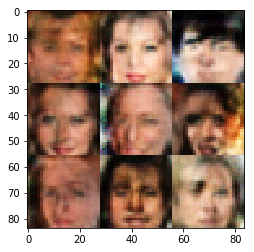

Epoch 1/1, step 2910... Discriminator Loss: 1.3268... Generator Loss: 0.7524
Epoch 1/1, step 2920... Discriminator Loss: 1.4629... Generator Loss: 0.9005
Epoch 1/1, step 2930... Discriminator Loss: 1.4818... Generator Loss: 0.7520
Epoch 1/1, step 2940... Discriminator Loss: 1.3276... Generator Loss: 0.8174
Epoch 1/1, step 2950... Discriminator Loss: 1.3883... Generator Loss: 0.6549
Epoch 1/1, step 2960... Discriminator Loss: 1.3342... Generator Loss: 0.7847
Epoch 1/1, step 2970... Discriminator Loss: 1.5379... Generator Loss: 0.6722
Epoch 1/1, step 2980... Discriminator Loss: 1.2614... Generator Loss: 0.7130
Epoch 1/1, step 2990... Discriminator Loss: 1.3627... Generator Loss: 0.6852
Epoch 1/1, step 3000... Discriminator Loss: 1.3169... Generator Loss: 0.6816


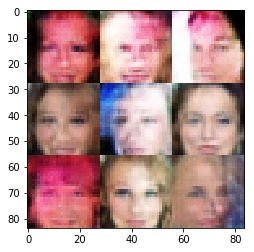

Epoch 1/1, step 3010... Discriminator Loss: 1.3608... Generator Loss: 0.7526
Epoch 1/1, step 3020... Discriminator Loss: 1.3303... Generator Loss: 0.7983
Epoch 1/1, step 3030... Discriminator Loss: 1.5329... Generator Loss: 0.6807
Epoch 1/1, step 3040... Discriminator Loss: 1.4096... Generator Loss: 0.6673
Epoch 1/1, step 3050... Discriminator Loss: 1.4564... Generator Loss: 0.6214
Epoch 1/1, step 3060... Discriminator Loss: 1.3639... Generator Loss: 0.7516
Epoch 1/1, step 3070... Discriminator Loss: 1.4013... Generator Loss: 0.6253
Epoch 1/1, step 3080... Discriminator Loss: 1.3165... Generator Loss: 0.7896
Epoch 1/1, step 3090... Discriminator Loss: 1.5414... Generator Loss: 0.7478
Epoch 1/1, step 3100... Discriminator Loss: 1.4389... Generator Loss: 0.7272


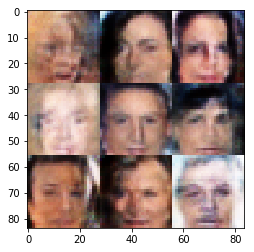

Epoch 1/1, step 3110... Discriminator Loss: 1.3475... Generator Loss: 0.7869
Epoch 1/1, step 3120... Discriminator Loss: 1.3039... Generator Loss: 0.8084
Epoch 1/1, step 3130... Discriminator Loss: 1.4542... Generator Loss: 0.6468
Epoch 1/1, step 3140... Discriminator Loss: 1.3350... Generator Loss: 0.8061
Epoch 1/1, step 3150... Discriminator Loss: 1.4048... Generator Loss: 0.6650
Epoch 1/1, step 3160... Discriminator Loss: 1.3831... Generator Loss: 0.7461
Epoch 1/1, step 3170... Discriminator Loss: 1.3434... Generator Loss: 0.8682
Epoch 1/1, step 3180... Discriminator Loss: 1.3539... Generator Loss: 0.6961
Epoch 1/1, step 3190... Discriminator Loss: 1.5405... Generator Loss: 0.6324
Epoch 1/1, step 3200... Discriminator Loss: 1.2812... Generator Loss: 0.7913


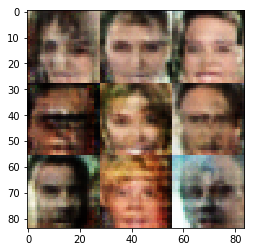

Epoch 1/1, step 3210... Discriminator Loss: 1.3958... Generator Loss: 0.7675
Epoch 1/1, step 3220... Discriminator Loss: 1.4622... Generator Loss: 0.6944
Epoch 1/1, step 3230... Discriminator Loss: 1.4835... Generator Loss: 0.6453
Epoch 1/1, step 3240... Discriminator Loss: 1.4528... Generator Loss: 0.6596
Epoch 1/1, step 3250... Discriminator Loss: 1.3894... Generator Loss: 0.7289
Epoch 1/1, step 3260... Discriminator Loss: 1.4182... Generator Loss: 0.6613
Epoch 1/1, step 3270... Discriminator Loss: 1.4683... Generator Loss: 0.6454
Epoch 1/1, step 3280... Discriminator Loss: 1.3576... Generator Loss: 0.7180
Epoch 1/1, step 3290... Discriminator Loss: 1.3937... Generator Loss: 0.6762
Epoch 1/1, step 3300... Discriminator Loss: 1.3969... Generator Loss: 0.7538


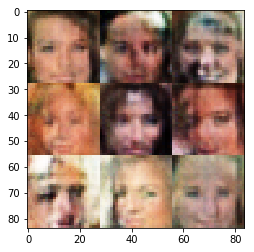

Epoch 1/1, step 3310... Discriminator Loss: 1.4009... Generator Loss: 0.7318
Epoch 1/1, step 3320... Discriminator Loss: 1.4036... Generator Loss: 0.7079
Epoch 1/1, step 3330... Discriminator Loss: 1.4214... Generator Loss: 0.5833
Epoch 1/1, step 3340... Discriminator Loss: 1.3799... Generator Loss: 0.6756
Epoch 1/1, step 3350... Discriminator Loss: 1.4206... Generator Loss: 0.7267
Epoch 1/1, step 3360... Discriminator Loss: 1.3884... Generator Loss: 0.7627
Epoch 1/1, step 3370... Discriminator Loss: 1.3462... Generator Loss: 0.7279
Epoch 1/1, step 3380... Discriminator Loss: 1.3755... Generator Loss: 0.7577
Epoch 1/1, step 3390... Discriminator Loss: 1.4540... Generator Loss: 0.6879
Epoch 1/1, step 3400... Discriminator Loss: 1.3924... Generator Loss: 0.7691


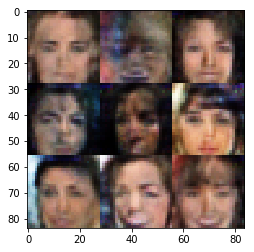

Epoch 1/1, step 3410... Discriminator Loss: 1.3778... Generator Loss: 0.7944
Epoch 1/1, step 3420... Discriminator Loss: 1.3632... Generator Loss: 0.7744
Epoch 1/1, step 3430... Discriminator Loss: 1.4571... Generator Loss: 0.7521
Epoch 1/1, step 3440... Discriminator Loss: 1.4110... Generator Loss: 0.6857
Epoch 1/1, step 3450... Discriminator Loss: 1.3821... Generator Loss: 0.6456
Epoch 1/1, step 3460... Discriminator Loss: 1.3996... Generator Loss: 0.7199
Epoch 1/1, step 3470... Discriminator Loss: 1.3228... Generator Loss: 0.7695
Epoch 1/1, step 3480... Discriminator Loss: 1.3478... Generator Loss: 0.7960
Epoch 1/1, step 3490... Discriminator Loss: 1.3619... Generator Loss: 0.7224
Epoch 1/1, step 3500... Discriminator Loss: 1.3114... Generator Loss: 0.7219


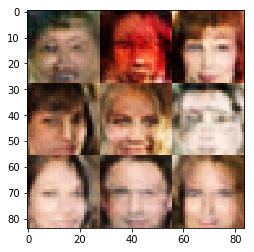

Epoch 1/1, step 3510... Discriminator Loss: 1.4212... Generator Loss: 0.7649
Epoch 1/1, step 3520... Discriminator Loss: 1.4358... Generator Loss: 0.5914
Epoch 1/1, step 3530... Discriminator Loss: 1.3287... Generator Loss: 0.7462
Epoch 1/1, step 3540... Discriminator Loss: 1.3662... Generator Loss: 0.6462
Epoch 1/1, step 3550... Discriminator Loss: 1.4006... Generator Loss: 0.6817
Epoch 1/1, step 3560... Discriminator Loss: 1.4391... Generator Loss: 0.7902
Epoch 1/1, step 3570... Discriminator Loss: 1.3649... Generator Loss: 0.7656
Epoch 1/1, step 3580... Discriminator Loss: 1.4967... Generator Loss: 0.7034
Epoch 1/1, step 3590... Discriminator Loss: 1.2627... Generator Loss: 0.8464
Epoch 1/1, step 3600... Discriminator Loss: 1.2912... Generator Loss: 0.8390


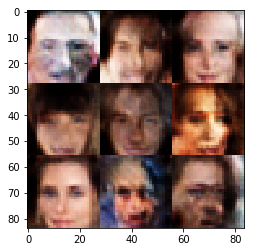

Epoch 1/1, step 3610... Discriminator Loss: 1.5134... Generator Loss: 1.1954
Epoch 1/1, step 3620... Discriminator Loss: 1.2919... Generator Loss: 0.7175
Epoch 1/1, step 3630... Discriminator Loss: 1.5011... Generator Loss: 0.7239
Epoch 1/1, step 3640... Discriminator Loss: 1.3076... Generator Loss: 0.7975
Epoch 1/1, step 3650... Discriminator Loss: 1.2760... Generator Loss: 0.9402
Epoch 1/1, step 3660... Discriminator Loss: 1.5000... Generator Loss: 0.6902
Epoch 1/1, step 3670... Discriminator Loss: 1.3469... Generator Loss: 0.7183
Epoch 1/1, step 3680... Discriminator Loss: 1.4706... Generator Loss: 0.8142
Epoch 1/1, step 3690... Discriminator Loss: 1.4964... Generator Loss: 0.6949
Epoch 1/1, step 3700... Discriminator Loss: 1.4031... Generator Loss: 0.7457


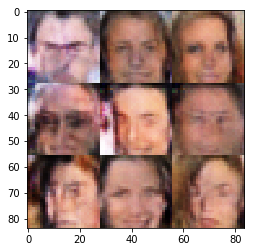

Epoch 1/1, step 3710... Discriminator Loss: 1.3929... Generator Loss: 0.7171
Epoch 1/1, step 3720... Discriminator Loss: 1.2429... Generator Loss: 0.7683
Epoch 1/1, step 3730... Discriminator Loss: 1.4717... Generator Loss: 0.6025
Epoch 1/1, step 3740... Discriminator Loss: 1.3843... Generator Loss: 0.6366
Epoch 1/1, step 3750... Discriminator Loss: 1.3636... Generator Loss: 0.7404
Epoch 1/1, step 3760... Discriminator Loss: 1.3818... Generator Loss: 0.8463
Epoch 1/1, step 3770... Discriminator Loss: 1.4087... Generator Loss: 0.8318
Epoch 1/1, step 3780... Discriminator Loss: 1.4946... Generator Loss: 0.6591
Epoch 1/1, step 3790... Discriminator Loss: 1.3897... Generator Loss: 0.7519
Epoch 1/1, step 3800... Discriminator Loss: 1.3004... Generator Loss: 0.7909


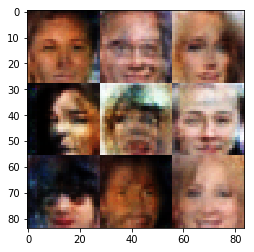

Epoch 1/1, step 3810... Discriminator Loss: 1.3666... Generator Loss: 0.8102
Epoch 1/1, step 3820... Discriminator Loss: 1.3432... Generator Loss: 0.7240
Epoch 1/1, step 3830... Discriminator Loss: 1.4387... Generator Loss: 0.7298
Epoch 1/1, step 3840... Discriminator Loss: 1.3009... Generator Loss: 0.7402
Epoch 1/1, step 3850... Discriminator Loss: 1.2446... Generator Loss: 0.7959
Epoch 1/1, step 3860... Discriminator Loss: 1.3322... Generator Loss: 0.8329
Epoch 1/1, step 3870... Discriminator Loss: 1.4212... Generator Loss: 0.7535
Epoch 1/1, step 3880... Discriminator Loss: 1.3250... Generator Loss: 0.8398
Epoch 1/1, step 3890... Discriminator Loss: 1.3506... Generator Loss: 0.7314
Epoch 1/1, step 3900... Discriminator Loss: 1.3372... Generator Loss: 0.7689


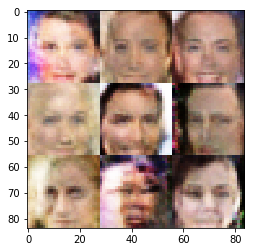

Epoch 1/1, step 3910... Discriminator Loss: 1.3475... Generator Loss: 0.7428
Epoch 1/1, step 3920... Discriminator Loss: 1.1450... Generator Loss: 0.8342
Epoch 1/1, step 3930... Discriminator Loss: 1.5376... Generator Loss: 0.5617
Epoch 1/1, step 3940... Discriminator Loss: 1.3750... Generator Loss: 0.7523
Epoch 1/1, step 3950... Discriminator Loss: 1.4087... Generator Loss: 0.6845
Epoch 1/1, step 3960... Discriminator Loss: 1.4682... Generator Loss: 0.6448
Epoch 1/1, step 3970... Discriminator Loss: 1.3257... Generator Loss: 0.7464
Epoch 1/1, step 3980... Discriminator Loss: 1.3348... Generator Loss: 0.6565
Epoch 1/1, step 3990... Discriminator Loss: 1.3889... Generator Loss: 0.7234
Epoch 1/1, step 4000... Discriminator Loss: 1.3241... Generator Loss: 0.7948


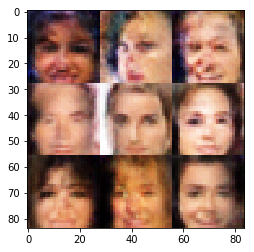

Epoch 1/1, step 4010... Discriminator Loss: 1.3572... Generator Loss: 0.6871
Epoch 1/1, step 4020... Discriminator Loss: 1.4608... Generator Loss: 0.7098
Epoch 1/1, step 4030... Discriminator Loss: 1.4194... Generator Loss: 0.6825
Epoch 1/1, step 4040... Discriminator Loss: 1.3687... Generator Loss: 0.7146
Epoch 1/1, step 4050... Discriminator Loss: 1.3548... Generator Loss: 0.7065
Epoch 1/1, step 4060... Discriminator Loss: 1.3900... Generator Loss: 0.6524
Epoch 1/1, step 4070... Discriminator Loss: 1.4077... Generator Loss: 0.7271
Epoch 1/1, step 4080... Discriminator Loss: 1.3367... Generator Loss: 0.8266
Epoch 1/1, step 4090... Discriminator Loss: 1.5177... Generator Loss: 0.7696
Epoch 1/1, step 4100... Discriminator Loss: 1.3350... Generator Loss: 0.8190


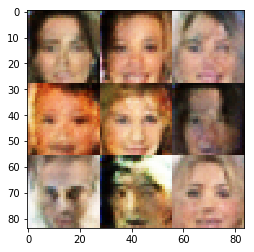

Epoch 1/1, step 4110... Discriminator Loss: 1.3766... Generator Loss: 0.7062
Epoch 1/1, step 4120... Discriminator Loss: 1.3332... Generator Loss: 0.7281
Epoch 1/1, step 4130... Discriminator Loss: 1.4428... Generator Loss: 0.6963
Epoch 1/1, step 4140... Discriminator Loss: 1.3040... Generator Loss: 0.7465
Epoch 1/1, step 4150... Discriminator Loss: 1.4048... Generator Loss: 0.6540
Epoch 1/1, step 4160... Discriminator Loss: 1.2817... Generator Loss: 0.7339
Epoch 1/1, step 4170... Discriminator Loss: 1.4053... Generator Loss: 0.6950
Epoch 1/1, step 4180... Discriminator Loss: 1.3798... Generator Loss: 0.6506
Epoch 1/1, step 4190... Discriminator Loss: 1.3958... Generator Loss: 0.6863
Epoch 1/1, step 4200... Discriminator Loss: 1.5105... Generator Loss: 0.4854


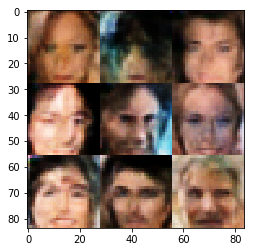

Epoch 1/1, step 4210... Discriminator Loss: 1.3029... Generator Loss: 0.7774
Epoch 1/1, step 4220... Discriminator Loss: 1.3692... Generator Loss: 0.8542
Epoch 1/1, step 4230... Discriminator Loss: 1.2888... Generator Loss: 0.7301
Epoch 1/1, step 4240... Discriminator Loss: 1.3471... Generator Loss: 0.6744
Epoch 1/1, step 4250... Discriminator Loss: 1.2698... Generator Loss: 0.8882
Epoch 1/1, step 4260... Discriminator Loss: 1.5128... Generator Loss: 0.7301
Epoch 1/1, step 4270... Discriminator Loss: 1.4110... Generator Loss: 0.6624
Epoch 1/1, step 4280... Discriminator Loss: 1.3723... Generator Loss: 0.6818
Epoch 1/1, step 4290... Discriminator Loss: 1.3859... Generator Loss: 0.6945
Epoch 1/1, step 4300... Discriminator Loss: 1.4904... Generator Loss: 0.6320


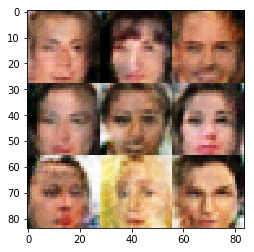

Epoch 1/1, step 4310... Discriminator Loss: 1.4146... Generator Loss: 0.6545
Epoch 1/1, step 4320... Discriminator Loss: 1.0810... Generator Loss: 1.0443
Epoch 1/1, step 4330... Discriminator Loss: 1.3615... Generator Loss: 0.6945
Epoch 1/1, step 4340... Discriminator Loss: 1.3241... Generator Loss: 0.7423
Epoch 1/1, step 4350... Discriminator Loss: 1.3320... Generator Loss: 0.6374
Epoch 1/1, step 4360... Discriminator Loss: 1.3310... Generator Loss: 0.7876
Epoch 1/1, step 4370... Discriminator Loss: 1.3549... Generator Loss: 0.6704
Epoch 1/1, step 4380... Discriminator Loss: 1.4972... Generator Loss: 0.7339
Epoch 1/1, step 4390... Discriminator Loss: 1.3133... Generator Loss: 0.7096
Epoch 1/1, step 4400... Discriminator Loss: 1.3344... Generator Loss: 0.7068


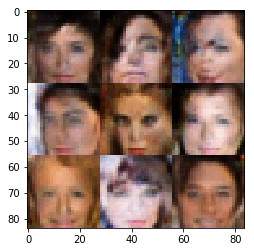

Epoch 1/1, step 4410... Discriminator Loss: 1.4045... Generator Loss: 0.6947
Epoch 1/1, step 4420... Discriminator Loss: 1.4246... Generator Loss: 0.6768
Epoch 1/1, step 4430... Discriminator Loss: 1.3616... Generator Loss: 0.7458
Epoch 1/1, step 4440... Discriminator Loss: 1.4803... Generator Loss: 0.6752
Epoch 1/1, step 4450... Discriminator Loss: 1.4508... Generator Loss: 0.6204
Epoch 1/1, step 4460... Discriminator Loss: 1.3475... Generator Loss: 0.7058
Epoch 1/1, step 4470... Discriminator Loss: 1.4802... Generator Loss: 0.6405
Epoch 1/1, step 4480... Discriminator Loss: 1.4815... Generator Loss: 0.6106
Epoch 1/1, step 4490... Discriminator Loss: 1.2991... Generator Loss: 0.7023
Epoch 1/1, step 4500... Discriminator Loss: 1.4650... Generator Loss: 0.6059


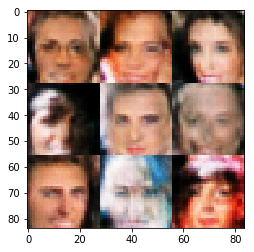

Epoch 1/1, step 4510... Discriminator Loss: 1.4620... Generator Loss: 0.6020
Epoch 1/1, step 4520... Discriminator Loss: 1.3578... Generator Loss: 0.6952
Epoch 1/1, step 4530... Discriminator Loss: 1.5187... Generator Loss: 0.7872
Epoch 1/1, step 4540... Discriminator Loss: 1.5681... Generator Loss: 0.5642
Epoch 1/1, step 4550... Discriminator Loss: 1.4591... Generator Loss: 0.6795
Epoch 1/1, step 4560... Discriminator Loss: 1.3724... Generator Loss: 0.8484
Epoch 1/1, step 4570... Discriminator Loss: 1.3449... Generator Loss: 0.7589
Epoch 1/1, step 4580... Discriminator Loss: 1.4321... Generator Loss: 0.6522
Epoch 1/1, step 4590... Discriminator Loss: 1.3276... Generator Loss: 0.8511
Epoch 1/1, step 4600... Discriminator Loss: 1.3690... Generator Loss: 0.6788


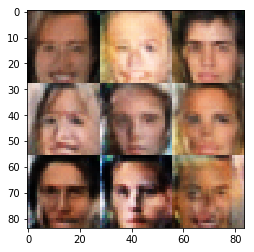

Epoch 1/1, step 4610... Discriminator Loss: 1.3903... Generator Loss: 0.7066
Epoch 1/1, step 4620... Discriminator Loss: 1.3054... Generator Loss: 0.7749
Epoch 1/1, step 4630... Discriminator Loss: 1.3414... Generator Loss: 0.6979
Epoch 1/1, step 4640... Discriminator Loss: 1.4952... Generator Loss: 0.7347
Epoch 1/1, step 4650... Discriminator Loss: 1.4377... Generator Loss: 0.6408
Epoch 1/1, step 4660... Discriminator Loss: 1.4175... Generator Loss: 0.6765
Epoch 1/1, step 4670... Discriminator Loss: 1.4640... Generator Loss: 0.6256
Epoch 1/1, step 4680... Discriminator Loss: 1.4433... Generator Loss: 0.7040
Epoch 1/1, step 4690... Discriminator Loss: 1.4279... Generator Loss: 0.7221
Epoch 1/1, step 4700... Discriminator Loss: 1.2725... Generator Loss: 0.8541


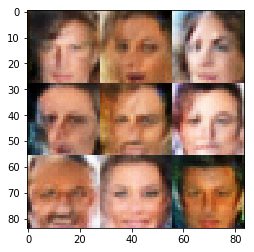

Epoch 1/1, step 4710... Discriminator Loss: 1.4630... Generator Loss: 0.7216
Epoch 1/1, step 4720... Discriminator Loss: 1.3820... Generator Loss: 0.7063
Epoch 1/1, step 4730... Discriminator Loss: 1.6001... Generator Loss: 0.6932
Epoch 1/1, step 4740... Discriminator Loss: 1.4538... Generator Loss: 0.6349
Epoch 1/1, step 4750... Discriminator Loss: 1.3589... Generator Loss: 0.8223
Epoch 1/1, step 4760... Discriminator Loss: 1.3256... Generator Loss: 0.7851
Epoch 1/1, step 4770... Discriminator Loss: 1.4471... Generator Loss: 0.7289
Epoch 1/1, step 4780... Discriminator Loss: 1.3778... Generator Loss: 0.6852
Epoch 1/1, step 4790... Discriminator Loss: 1.4202... Generator Loss: 0.6881
Epoch 1/1, step 4800... Discriminator Loss: 1.3675... Generator Loss: 0.7459


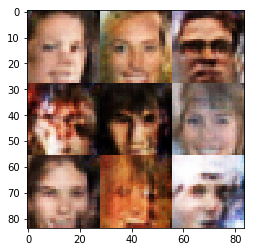

Epoch 1/1, step 4810... Discriminator Loss: 1.4288... Generator Loss: 0.7508
Epoch 1/1, step 4820... Discriminator Loss: 1.2913... Generator Loss: 0.7990
Epoch 1/1, step 4830... Discriminator Loss: 1.4408... Generator Loss: 0.7852
Epoch 1/1, step 4840... Discriminator Loss: 1.4107... Generator Loss: 0.7491
Epoch 1/1, step 4850... Discriminator Loss: 1.2614... Generator Loss: 0.7546
Epoch 1/1, step 4860... Discriminator Loss: 1.3817... Generator Loss: 0.7600
Epoch 1/1, step 4870... Discriminator Loss: 1.2538... Generator Loss: 0.9141
Epoch 1/1, step 4880... Discriminator Loss: 1.3773... Generator Loss: 0.7429
Epoch 1/1, step 4890... Discriminator Loss: 1.3951... Generator Loss: 0.7123
Epoch 1/1, step 4900... Discriminator Loss: 1.4418... Generator Loss: 0.6653


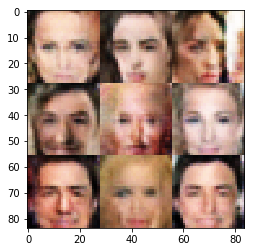

Epoch 1/1, step 4910... Discriminator Loss: 1.3270... Generator Loss: 0.7517
Epoch 1/1, step 4920... Discriminator Loss: 1.4033... Generator Loss: 0.7990
Epoch 1/1, step 4930... Discriminator Loss: 1.3749... Generator Loss: 0.7172
Epoch 1/1, step 4940... Discriminator Loss: 1.4093... Generator Loss: 0.7934
Epoch 1/1, step 4950... Discriminator Loss: 1.3495... Generator Loss: 0.7288
Epoch 1/1, step 4960... Discriminator Loss: 1.4445... Generator Loss: 0.7039
Epoch 1/1, step 4970... Discriminator Loss: 1.5473... Generator Loss: 0.5867
Epoch 1/1, step 4980... Discriminator Loss: 1.4080... Generator Loss: 0.7215
Epoch 1/1, step 4990... Discriminator Loss: 1.3395... Generator Loss: 0.7629
Epoch 1/1, step 5000... Discriminator Loss: 1.4118... Generator Loss: 0.6319


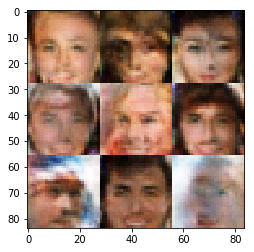

Epoch 1/1, step 5010... Discriminator Loss: 1.4199... Generator Loss: 0.6635
Epoch 1/1, step 5020... Discriminator Loss: 1.2616... Generator Loss: 0.7722
Epoch 1/1, step 5030... Discriminator Loss: 1.4553... Generator Loss: 0.5867
Epoch 1/1, step 5040... Discriminator Loss: 1.3637... Generator Loss: 0.7664
Epoch 1/1, step 5050... Discriminator Loss: 1.4097... Generator Loss: 0.6844
Epoch 1/1, step 5060... Discriminator Loss: 1.3619... Generator Loss: 0.7739
Epoch 1/1, step 5070... Discriminator Loss: 1.4245... Generator Loss: 0.7426
Epoch 1/1, step 5080... Discriminator Loss: 1.3562... Generator Loss: 0.7884
Epoch 1/1, step 5090... Discriminator Loss: 1.3393... Generator Loss: 0.7083
Epoch 1/1, step 5100... Discriminator Loss: 1.3447... Generator Loss: 0.7190


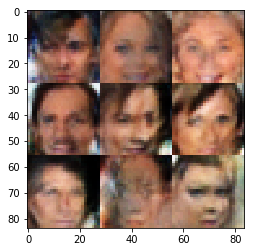

Epoch 1/1, step 5110... Discriminator Loss: 1.4303... Generator Loss: 0.6981
Epoch 1/1, step 5120... Discriminator Loss: 1.3991... Generator Loss: 0.7708
Epoch 1/1, step 5130... Discriminator Loss: 1.4439... Generator Loss: 0.6992
Epoch 1/1, step 5140... Discriminator Loss: 1.2313... Generator Loss: 0.7520
Epoch 1/1, step 5150... Discriminator Loss: 1.4450... Generator Loss: 0.6721
Epoch 1/1, step 5160... Discriminator Loss: 1.3770... Generator Loss: 0.7788
Epoch 1/1, step 5170... Discriminator Loss: 1.4142... Generator Loss: 0.7360
Epoch 1/1, step 5180... Discriminator Loss: 1.3385... Generator Loss: 0.7733
Epoch 1/1, step 5190... Discriminator Loss: 1.3969... Generator Loss: 0.7955
Epoch 1/1, step 5200... Discriminator Loss: 1.4419... Generator Loss: 0.6647


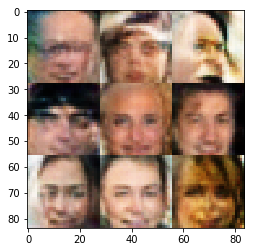

Epoch 1/1, step 5210... Discriminator Loss: 1.3493... Generator Loss: 0.7859
Epoch 1/1, step 5220... Discriminator Loss: 1.3506... Generator Loss: 0.7060
Epoch 1/1, step 5230... Discriminator Loss: 1.4397... Generator Loss: 0.6968
Epoch 1/1, step 5240... Discriminator Loss: 1.3231... Generator Loss: 0.7313
Epoch 1/1, step 5250... Discriminator Loss: 1.3624... Generator Loss: 0.7147
Epoch 1/1, step 5260... Discriminator Loss: 1.3775... Generator Loss: 0.7203
Epoch 1/1, step 5270... Discriminator Loss: 1.3991... Generator Loss: 0.7299
Epoch 1/1, step 5280... Discriminator Loss: 1.3094... Generator Loss: 0.7674
Epoch 1/1, step 5290... Discriminator Loss: 1.4245... Generator Loss: 0.7387
Epoch 1/1, step 5300... Discriminator Loss: 1.3937... Generator Loss: 0.7652


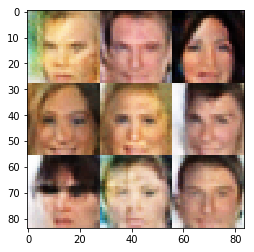

Epoch 1/1, step 5310... Discriminator Loss: 1.4466... Generator Loss: 0.6810
Epoch 1/1, step 5320... Discriminator Loss: 1.3294... Generator Loss: 0.7621
Epoch 1/1, step 5330... Discriminator Loss: 1.3674... Generator Loss: 0.7008
Epoch 1/1, step 5340... Discriminator Loss: 1.4245... Generator Loss: 0.7191
Epoch 1/1, step 5350... Discriminator Loss: 1.3284... Generator Loss: 0.8019
Epoch 1/1, step 5360... Discriminator Loss: 1.4053... Generator Loss: 0.7110
Epoch 1/1, step 5370... Discriminator Loss: 1.3275... Generator Loss: 0.7447
Epoch 1/1, step 5380... Discriminator Loss: 1.3535... Generator Loss: 0.7584
Epoch 1/1, step 5390... Discriminator Loss: 1.4023... Generator Loss: 0.7185
Epoch 1/1, step 5400... Discriminator Loss: 1.3657... Generator Loss: 0.8036


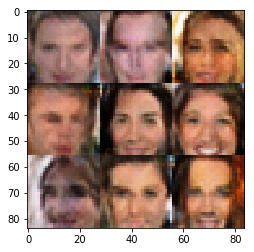

Epoch 1/1, step 5410... Discriminator Loss: 1.4212... Generator Loss: 0.6975
Epoch 1/1, step 5420... Discriminator Loss: 1.4294... Generator Loss: 0.6646
Epoch 1/1, step 5430... Discriminator Loss: 1.4754... Generator Loss: 0.6297
Epoch 1/1, step 5440... Discriminator Loss: 1.4446... Generator Loss: 0.6496
Epoch 1/1, step 5450... Discriminator Loss: 1.2612... Generator Loss: 0.8414
Epoch 1/1, step 5460... Discriminator Loss: 1.4016... Generator Loss: 0.7290
Epoch 1/1, step 5470... Discriminator Loss: 1.4476... Generator Loss: 0.7335
Epoch 1/1, step 5480... Discriminator Loss: 1.4275... Generator Loss: 0.7295
Epoch 1/1, step 5490... Discriminator Loss: 1.4432... Generator Loss: 0.7135
Epoch 1/1, step 5500... Discriminator Loss: 1.3340... Generator Loss: 0.7082


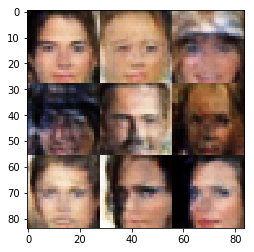

Epoch 1/1, step 5510... Discriminator Loss: 1.4205... Generator Loss: 0.6743
Epoch 1/1, step 5520... Discriminator Loss: 1.3673... Generator Loss: 0.8316
Epoch 1/1, step 5530... Discriminator Loss: 1.3153... Generator Loss: 0.8709
Epoch 1/1, step 5540... Discriminator Loss: 1.3017... Generator Loss: 0.8425
Epoch 1/1, step 5550... Discriminator Loss: 1.3662... Generator Loss: 0.7609
Epoch 1/1, step 5560... Discriminator Loss: 1.3379... Generator Loss: 0.7650
Epoch 1/1, step 5570... Discriminator Loss: 1.3692... Generator Loss: 0.7507
Epoch 1/1, step 5580... Discriminator Loss: 1.3537... Generator Loss: 0.7058
Epoch 1/1, step 5590... Discriminator Loss: 1.3403... Generator Loss: 0.7107
Epoch 1/1, step 5600... Discriminator Loss: 1.4763... Generator Loss: 0.6238


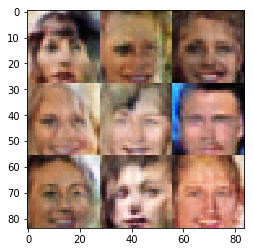

Epoch 1/1, step 5610... Discriminator Loss: 1.2779... Generator Loss: 0.8164
Epoch 1/1, step 5620... Discriminator Loss: 1.2994... Generator Loss: 0.7858
Epoch 1/1, step 5630... Discriminator Loss: 1.3149... Generator Loss: 0.7857
Epoch 1/1, step 5640... Discriminator Loss: 1.3962... Generator Loss: 0.6590
Epoch 1/1, step 5650... Discriminator Loss: 1.4359... Generator Loss: 0.7181
Epoch 1/1, step 5660... Discriminator Loss: 1.3154... Generator Loss: 0.7933
Epoch 1/1, step 5670... Discriminator Loss: 1.4600... Generator Loss: 0.7261
Epoch 1/1, step 5680... Discriminator Loss: 1.4360... Generator Loss: 0.7554
Epoch 1/1, step 5690... Discriminator Loss: 1.3832... Generator Loss: 0.7095
Epoch 1/1, step 5700... Discriminator Loss: 1.3414... Generator Loss: 0.7910


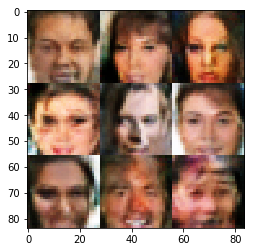

Epoch 1/1, step 5710... Discriminator Loss: 1.3945... Generator Loss: 0.7050
Epoch 1/1, step 5720... Discriminator Loss: 1.3660... Generator Loss: 0.7724
Epoch 1/1, step 5730... Discriminator Loss: 1.4316... Generator Loss: 0.6592
Epoch 1/1, step 5740... Discriminator Loss: 1.4070... Generator Loss: 0.7703
Epoch 1/1, step 5750... Discriminator Loss: 1.3613... Generator Loss: 0.6649
Epoch 1/1, step 5760... Discriminator Loss: 1.4551... Generator Loss: 0.6508
Epoch 1/1, step 5770... Discriminator Loss: 1.4172... Generator Loss: 0.7590
Epoch 1/1, step 5780... Discriminator Loss: 1.4311... Generator Loss: 0.7374
Epoch 1/1, step 5790... Discriminator Loss: 1.3947... Generator Loss: 0.7108
Epoch 1/1, step 5800... Discriminator Loss: 1.4623... Generator Loss: 0.6746


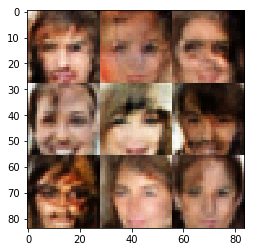

Epoch 1/1, step 5810... Discriminator Loss: 1.3331... Generator Loss: 0.7383
Epoch 1/1, step 5820... Discriminator Loss: 1.3804... Generator Loss: 0.7128
Epoch 1/1, step 5830... Discriminator Loss: 1.4272... Generator Loss: 0.7043
Epoch 1/1, step 5840... Discriminator Loss: 1.3502... Generator Loss: 0.7335
Epoch 1/1, step 5850... Discriminator Loss: 1.2961... Generator Loss: 0.8226
Epoch 1/1, step 5860... Discriminator Loss: 1.5237... Generator Loss: 0.6374
Epoch 1/1, step 5870... Discriminator Loss: 1.3007... Generator Loss: 0.8775
Epoch 1/1, step 5880... Discriminator Loss: 1.4070... Generator Loss: 0.7315
Epoch 1/1, step 5890... Discriminator Loss: 1.4225... Generator Loss: 0.6953
Epoch 1/1, step 5900... Discriminator Loss: 1.3965... Generator Loss: 0.7482


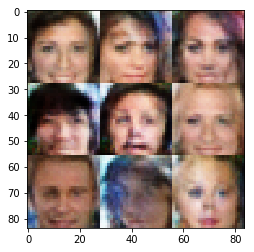

Epoch 1/1, step 5910... Discriminator Loss: 1.3743... Generator Loss: 0.7821
Epoch 1/1, step 5920... Discriminator Loss: 1.4486... Generator Loss: 0.6757
Epoch 1/1, step 5930... Discriminator Loss: 1.3898... Generator Loss: 0.7469
Epoch 1/1, step 5940... Discriminator Loss: 1.3644... Generator Loss: 0.7804
Epoch 1/1, step 5950... Discriminator Loss: 1.3352... Generator Loss: 0.7466
Epoch 1/1, step 5960... Discriminator Loss: 1.3794... Generator Loss: 0.7317
Epoch 1/1, step 5970... Discriminator Loss: 1.3796... Generator Loss: 0.7208
Epoch 1/1, step 5980... Discriminator Loss: 1.4441... Generator Loss: 0.7843
Epoch 1/1, step 5990... Discriminator Loss: 1.4286... Generator Loss: 0.6602
Epoch 1/1, step 6000... Discriminator Loss: 1.4028... Generator Loss: 0.6999


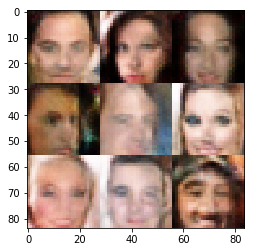

Epoch 1/1, step 6010... Discriminator Loss: 1.2953... Generator Loss: 0.7847
Epoch 1/1, step 6020... Discriminator Loss: 1.4569... Generator Loss: 0.6997
Epoch 1/1, step 6030... Discriminator Loss: 1.4083... Generator Loss: 0.7187
Epoch 1/1, step 6040... Discriminator Loss: 1.3251... Generator Loss: 0.7727
Epoch 1/1, step 6050... Discriminator Loss: 1.4003... Generator Loss: 0.7027
Epoch 1/1, step 6060... Discriminator Loss: 1.4167... Generator Loss: 0.7198
Epoch 1/1, step 6070... Discriminator Loss: 1.3223... Generator Loss: 0.7462
Epoch 1/1, step 6080... Discriminator Loss: 1.3889... Generator Loss: 0.7413
Epoch 1/1, step 6090... Discriminator Loss: 1.4247... Generator Loss: 0.6979
Epoch 1/1, step 6100... Discriminator Loss: 1.4270... Generator Loss: 0.6908


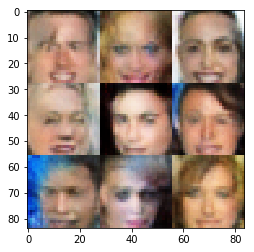

Epoch 1/1, step 6110... Discriminator Loss: 1.4657... Generator Loss: 0.6707
Epoch 1/1, step 6120... Discriminator Loss: 1.3848... Generator Loss: 0.7109
Epoch 1/1, step 6130... Discriminator Loss: 1.3778... Generator Loss: 0.7145
Epoch 1/1, step 6140... Discriminator Loss: 1.3234... Generator Loss: 0.7420
Epoch 1/1, step 6150... Discriminator Loss: 1.4606... Generator Loss: 0.6635
Epoch 1/1, step 6160... Discriminator Loss: 1.3550... Generator Loss: 0.7788
Epoch 1/1, step 6170... Discriminator Loss: 1.3695... Generator Loss: 0.7198
Epoch 1/1, step 6180... Discriminator Loss: 1.3255... Generator Loss: 0.7276
Epoch 1/1, step 6190... Discriminator Loss: 1.3919... Generator Loss: 0.6946
Epoch 1/1, step 6200... Discriminator Loss: 1.3480... Generator Loss: 0.7454


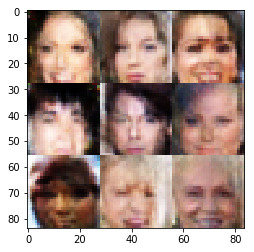

Epoch 1/1, step 6210... Discriminator Loss: 1.2675... Generator Loss: 0.8482
Epoch 1/1, step 6220... Discriminator Loss: 1.4097... Generator Loss: 0.7007
Epoch 1/1, step 6230... Discriminator Loss: 1.3385... Generator Loss: 0.7625
Epoch 1/1, step 6240... Discriminator Loss: 1.4460... Generator Loss: 0.7257
Epoch 1/1, step 6250... Discriminator Loss: 1.3182... Generator Loss: 0.7191
Epoch 1/1, step 6260... Discriminator Loss: 1.3957... Generator Loss: 0.6984
Epoch 1/1, step 6270... Discriminator Loss: 1.3812... Generator Loss: 0.7037
Epoch 1/1, step 6280... Discriminator Loss: 1.4520... Generator Loss: 0.6881
Epoch 1/1, step 6290... Discriminator Loss: 1.3369... Generator Loss: 0.7977
Epoch 1/1, step 6300... Discriminator Loss: 1.3048... Generator Loss: 0.8595


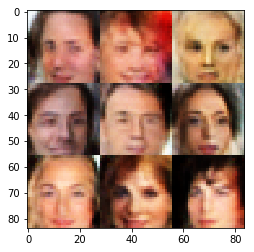

Epoch 1/1, step 6310... Discriminator Loss: 1.4931... Generator Loss: 0.7188
Epoch 1/1, step 6320... Discriminator Loss: 1.3363... Generator Loss: 0.8280
Epoch 1/1, step 6330... Discriminator Loss: 1.4054... Generator Loss: 0.7667


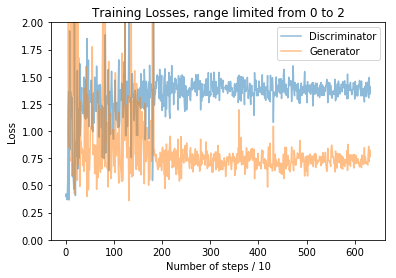

In [57]:
# Parameters defined in the code above are the same as for MNIST, but hyperparameters here are tuned for the CelebA data.
# Modified batch_size - gives slightly better results on CelebA data.
batch_size = 32
z_dim = 100
learning_rate = 0.0004
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Notes on the Output
The loss of the Generator and Discriminator both seems to converge more quickly for CelebA than the MNIST data and before the end the generated images are blurry but recognizably distinct faces.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.